In [4]:
import os
from IPython.display import Image as ipy_image
from IPython.display import display

#from utils.demo_util import get_shape_comp_model, get_shape_comp_opt, make_dummy_batch
#from utils.qual_util import load_bert2vqsc_model, get_lang_prob, save_mesh_as_gif
from utils.qual_util import get_lang_prob, save_mesh_as_gif
from utils.util import seed_everything
from utils.util_3d import init_mesh_renderer, sdf_to_mesh
import os
from termcolor import colored, cprint
import torch
import utils.util as util
from tqdm.notebook import tqdm

from datasets.ys_shapeset import  ShapeNetZSets

from datasets.text2shape import  Text2Shape





import cv2
import numpy as np
import imageio
from PIL import Image
from einops import rearrange
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms

from pytorch3d import structures

from utils.util_3d import sdf_to_mesh, render_mesh, rotate_mesh_360


from datasets.text2shape import  Text2Shape


%reload_ext autoreload
%autoreload 2

In [28]:
seed_everything(111)

description = "transformer visualize lablels"
res_dir = 'logs/transformer-sanity/unconditional'
if not os.path.exists(res_dir): os.makedirs(res_dir)

with open(f"{res_dir}/description.txt","w") as f:
    f.write(description)

gpu_id = 0
nimgs=6

class Opt:
    def __init__(self):
        self.name = 'opt'

In [6]:
def create_model(opt):
    model = None

    if opt.model == 'pvqvae':
        # vqvae
        from models.pvqvae_model import PVQVAEModel
        model = PVQVAEModel()
    elif opt.model == 'rand_tf':
        # transformer
        from models.rand_tf_model import RandTransformerModel
        model = RandTransformerModel()
    elif opt.model == 'rand_tf_old':
        from models.rand_tf_model_old import RandTransformerModelOld
        model = RandTransformerModelOld()
    elif opt.model == 'seq_tf':
        # seq-transformer
        from models.seq_tf_model import SeqTransformerModel
        model = SeqTransformerModel()
    elif opt.model == 'bert2vq':
        from models.bert2vq_model import BERT2VQModel
        model = BERT2VQModel()
    elif opt.model == "bert2vqsc":
        from models.bert2vq_scmodel import BERT2VQSCModel
        model = BERT2VQSCModel()
    elif opt.model == 'resnet2vq':
        from models.resnet2vq_model import ResNet2VQModel
        model = ResNet2VQModel()
    elif opt.model == 'resnet2vox':
        from models.resnet2vox_model import ResNet2VoxModel
        model = ResNet2VoxModel()
    elif opt.model == 'resnet2sdf':
        from models.resnet2sdf_model import ResNet2SDFModel
        model = ResNet2SDFModel()
    elif opt.model == 'baseline_je':
        from models.baseline_je_model import LangJEModel
        model = LangJEModel()
    elif opt.model == 'img_je':
        from models.img_je_model import ImgJEModel
        model = ImgJEModel()
    else:
        raise ValueError("Model [%s] not recognized." % opt.model)

    model.initialize(opt)
    cprint("[*] Model has been created: %s" % model.name(), 'blue')
    if(opt.ckpt is not None):
        model.load_ckpt(opt.ckpt)
        print("MODEL LOADED")
    return model

In [7]:
class Opt():
    print("class")
    
def get_shape_comp_opt(gpu_id=0):
    opt = Opt()

    # args
    gpuid=[gpu_id]
    batch_size=16
    max_dataset_size=64

    name='new_bert_overfit'

    # default args
    opt.serial_batches = False
    opt.nThreads = 4

    # important args
    opt.dataset_mode = 'shapenet_code'
    opt.bert_cfg = "./configs/bert2vqsc.yaml"
    opt.seed = 111
    opt.isTrain = True
    opt.gpu_ids = gpuid
    opt.max_dataset_size=64
    opt.device = 'cuda:%s' % gpuid[0]
    opt.batch_size = batch_size
    opt.max_dataset_size = max_dataset_size
    opt.logs_dir="logs"
    opt.name = name
    opt.lr = 1e-4
    opt.save_latest_freq = 1000
    opt.print_freq = 1
    #utils.util.seed_everything(opt.seed)
    opt.phase = 'test'
    opt.nepochs = 100
    opt.nepochs_decay = 60
    opt.mlp_layers = 3
    opt.mlp_hidden = 1024
    return opt
opt = get_shape_comp_opt()


def get_shape_comp_model(opt, model, ckpt):
    
    # load tf stuff
    opt.model=model
    opt.tf_cfg='configs/rand_tf_snet_code.yaml'
    opt.ckpt = ckpt
    
    # load vq stuff
    opt.vq_model='pvqvae'
    opt.vq_cfg='configs/pvqvae_snet.yaml'
    opt.vq_ckpt='../raw_dataset/checkpoints/vqvae.pth'
    
    ### opt.vq_dset='sdf_code' # original
    opt.vq_dset='snet'

    model = create_model(opt)
    print(f'[*] "{opt.model}" initialized.')
    model.load_ckpt(opt.ckpt)
        
    return model

class


In [17]:
dataset = Text2Shape()
#opt = Opt()

dataset.initialize(opt,isTrain=False)
dataset[0]["z_shape_target"].shape
dataset[0]["z_set_target"].shape

torch.Size([8, 8, 8])

In [9]:
opt = get_shape_comp_opt(gpu_id=gpu_id)
opt.dataset_mode = "text2shape"

#new_checkpoint_path = "logs/valid-valid-with-fusion-rand_tf-owndataset-chair-LR1e-4-clean-with-ckpt/ckpt/rand_tf_epoch-latest.pth"
new_checkpoint_path_V1 = "../raw_dataset/checkpoints_new/rand_tf_epoch_latest_fusion_transfer_v1.pth"
new_checkpoint_path_V2="../raw_dataset/checkpoints_new/rand_tf_epoch_latest_fusion_v2.pth"
new_checkpoint_path_V3 = "../raw_dataset/checkpoints_new/rand_tf_epoch_0_fusion_v3.pth"
new_checkpoint_path_V5 = "../raw_dataset/checkpoints_new/rand_tf_epoch-latest_v5.pth"


# modelV0 = get_shape_comp_model(opt,"rand_tf_old","../raw_dataset/checkpoints/rand_tf_singles_best.pth")    
# modelV0.eval()

# modelV4 =  get_shape_comp_model(opt,"rand_tf_old","../raw_dataset/checkpoints_new/rand_tf_250_epochs_v4.pth")
# modelV4.eval()

modelV1 = get_shape_comp_model(opt,"rand_tf",new_checkpoint_path_V1) 
modelV1.eval()

# modelV2 = get_shape_comp_model(opt,"rand_tf",new_checkpoint_path_V2)
# modelV2.eval()

# modelV3 = get_shape_comp_model(opt,"rand_tf",new_checkpoint_path_V3)
# modelV3.eval()

modelV5 = get_shape_comp_model(opt,"rand_tf",new_checkpoint_path_V5)
modelV5.eval()

[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: ../raw_dataset/checkpoints/vqvae.pth
---------- Networks initialized -------------
-----------------------------------------------
[*] Model has been created: Rand-Transformer-Model


/rhome/streakfull/.cache/pypoetry/virtualenvs/adl4cv-I-Koul65-py3.8/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[*] weight successfully load from: ../raw_dataset/checkpoints_new/rand_tf_epoch_latest_fusion_transfer_v1.pth
MODEL LOADED
[*] "rand_tf" initialized.
[*] weight successfully load from: ../raw_dataset/checkpoints_new/rand_tf_epoch_latest_fusion_transfer_v1.pth
[*] Enc has Attn at i_level, i_block: 3, 0
Working with z of shape (1, 256, 8, 8, 8) = 131072 dimensions.
[*] Dec has Attn at i_level, i_block: 3, 0
[*] VQVAE: weight successfully load from: ../raw_dataset/checkpoints/vqvae.pth
---------- Networks initialized -------------
-----------------------------------------------
[*] Model has been created: Rand-Transformer-Model
[*] weight successfully load from: ../raw_dataset/checkpoints_new/rand_tf_epoch-latest_v5.pth
MODEL LOADED
[*] "rand_tf" initialized.
[*] weight successfully load from: ../raw_dataset/checkpoints_new/rand_tf_epoch-latest_v5.pth


In [10]:
dist, elev, azim = 1.7, 20, 20
mesh_renderer = init_mesh_renderer(image_size=256, dist=dist, elev=elev, azim=azim, device=opt.device)

  0%|                                                                          | 0/64 [00:00<?, ?it/s]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/0-modelV5.gif


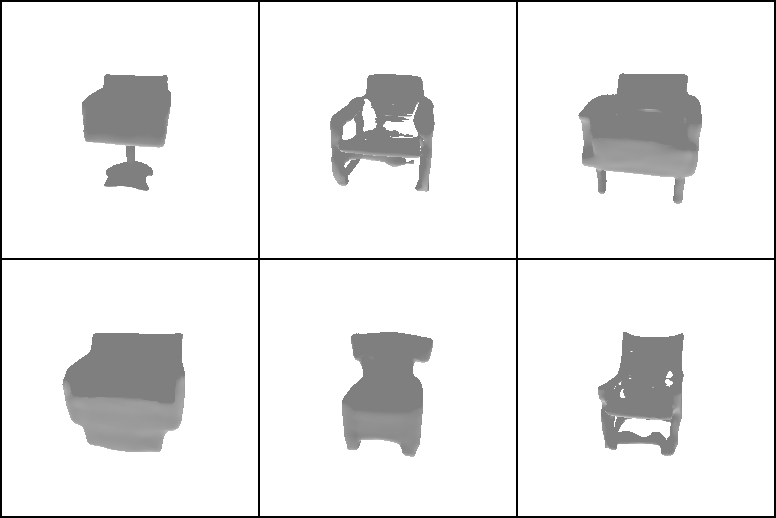

  2%|█                                                                 | 1/64 [00:07<08:13,  7.83s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/1-modelV5.gif


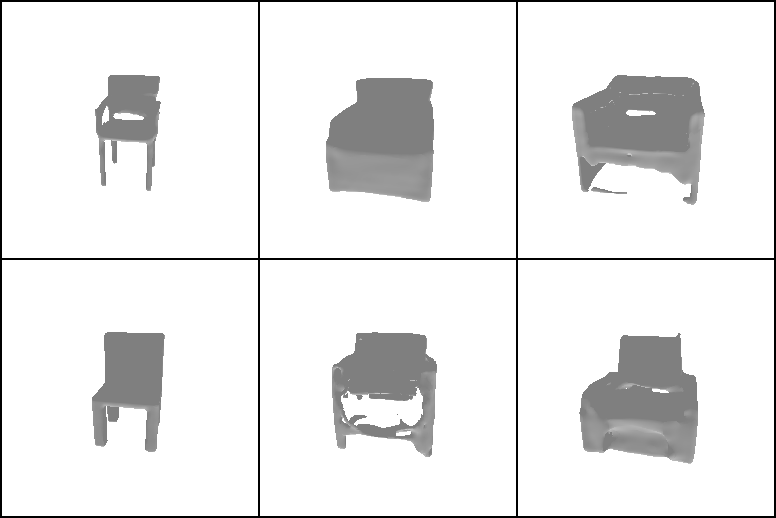

  3%|██                                                                | 2/64 [00:14<07:38,  7.39s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/2-modelV5.gif


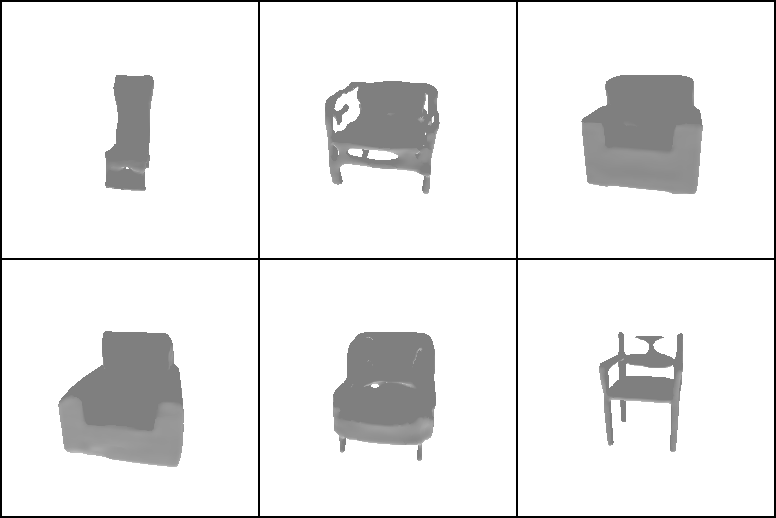

  5%|███                                                               | 3/64 [00:22<07:23,  7.27s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/3-modelV5.gif


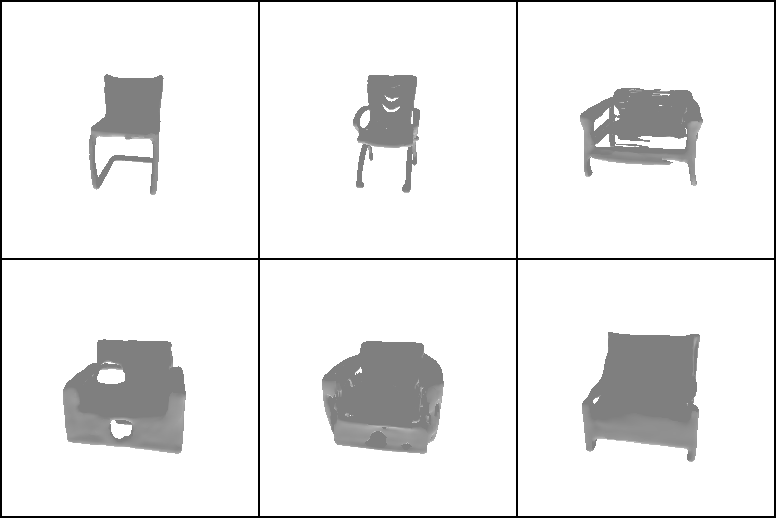

  6%|████▏                                                             | 4/64 [00:29<07:13,  7.23s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/4-modelV5.gif


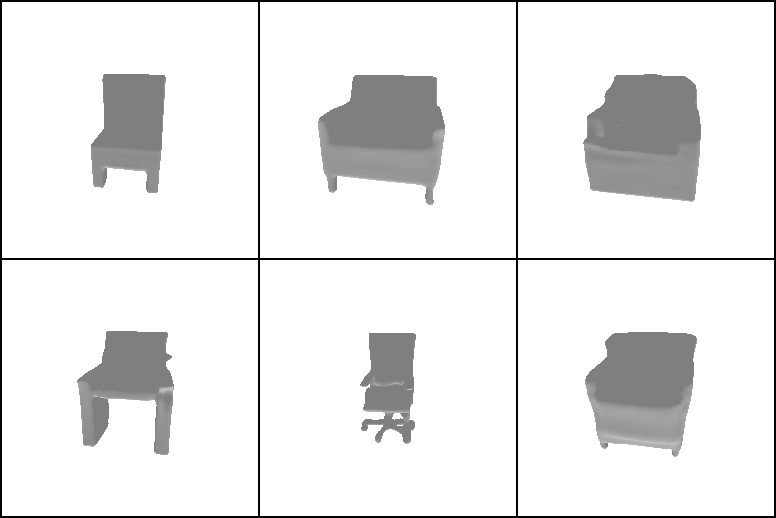

  8%|█████▏                                                            | 5/64 [00:36<07:04,  7.20s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/5-modelV5.gif


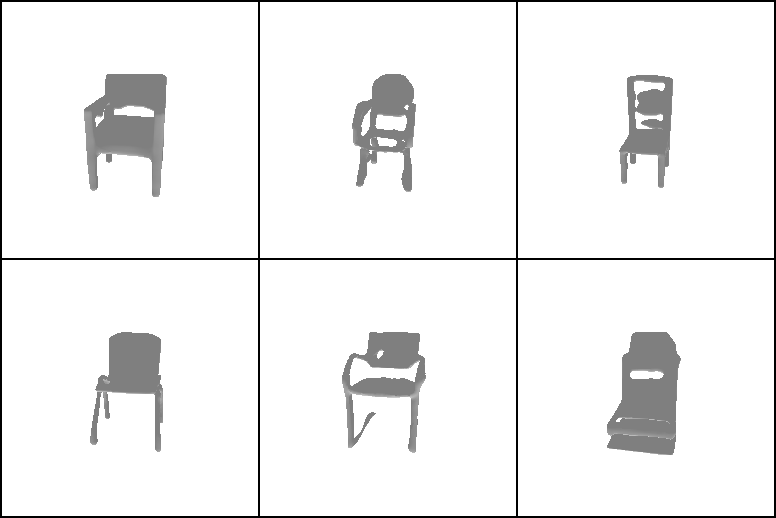

  9%|██████▏                                                           | 6/64 [00:43<06:55,  7.16s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/6-modelV5.gif


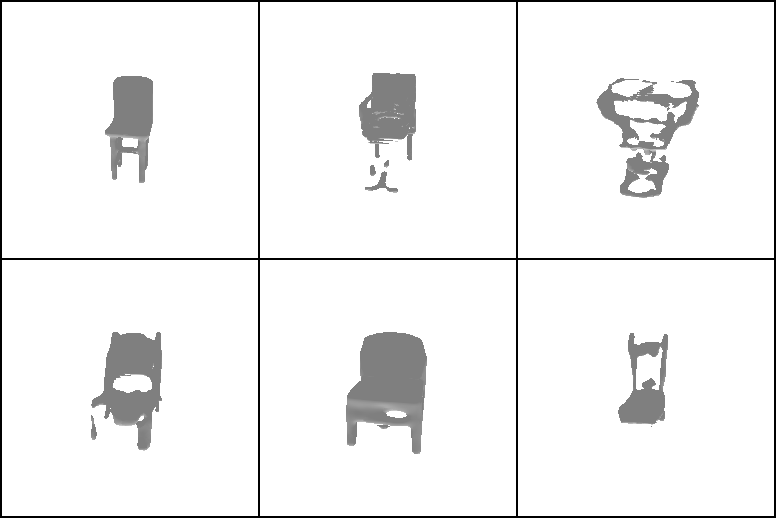

 11%|███████▏                                                          | 7/64 [00:50<06:47,  7.15s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/7-modelV5.gif


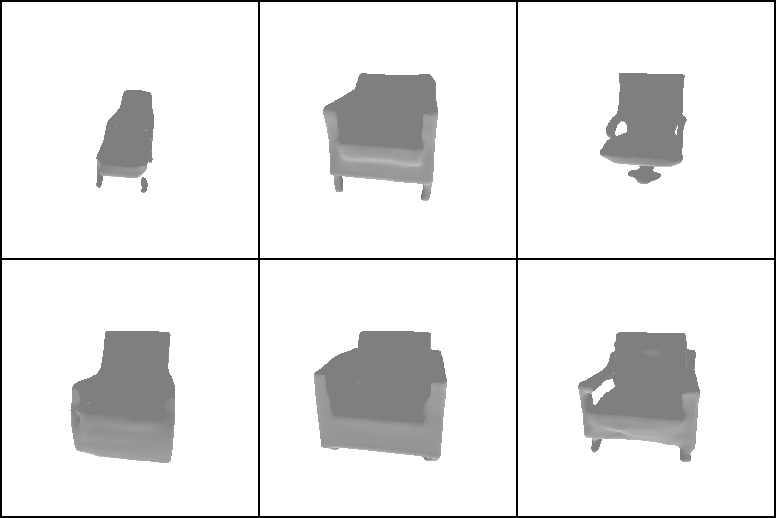

 12%|████████▎                                                         | 8/64 [00:57<06:39,  7.14s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/8-modelV5.gif


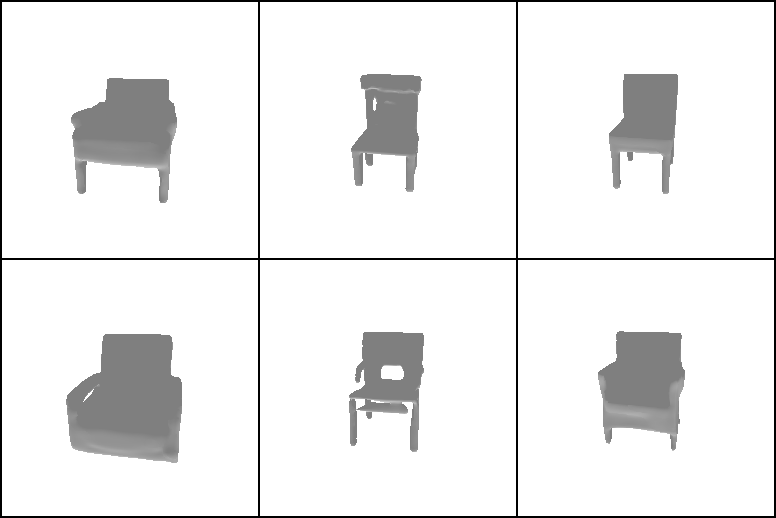

 14%|█████████▎                                                        | 9/64 [01:04<06:31,  7.12s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/9-modelV5.gif


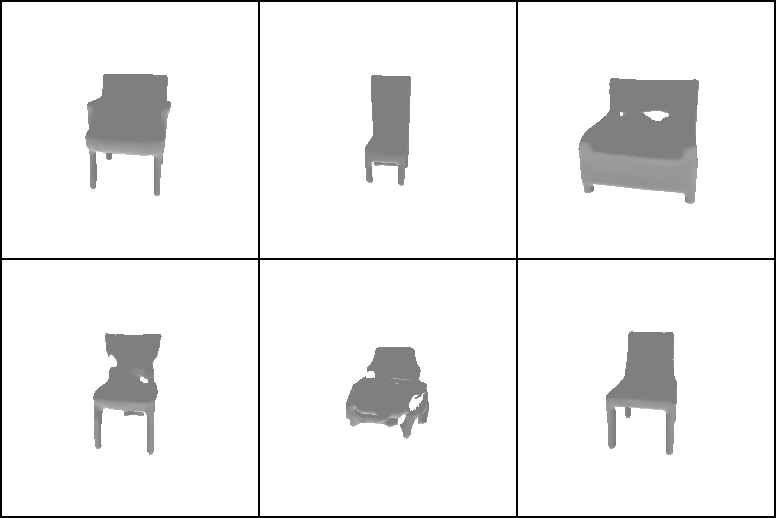

 16%|██████████▏                                                      | 10/64 [01:11<06:23,  7.11s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/10-modelV5.gif


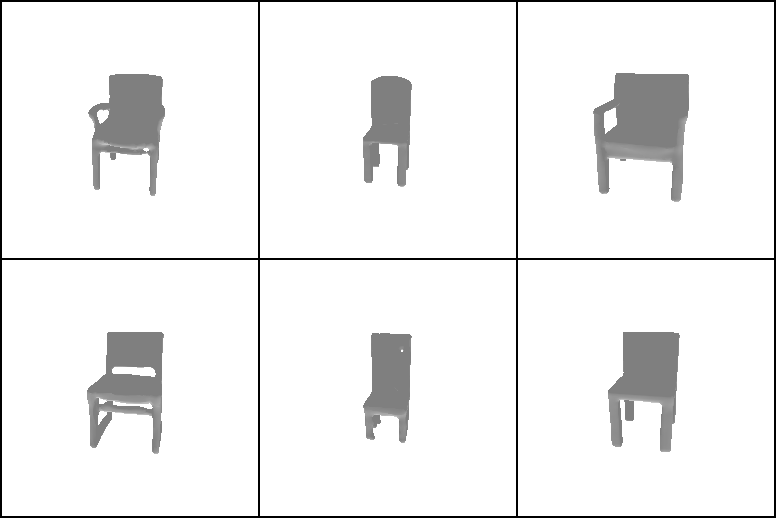

 17%|███████████▏                                                     | 11/64 [01:18<06:17,  7.12s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/11-modelV5.gif


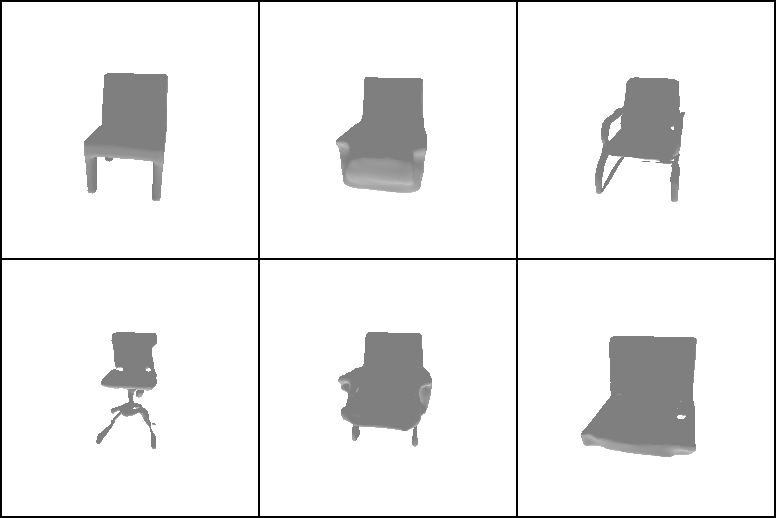

 19%|████████████▏                                                    | 12/64 [01:26<06:10,  7.13s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/12-modelV5.gif


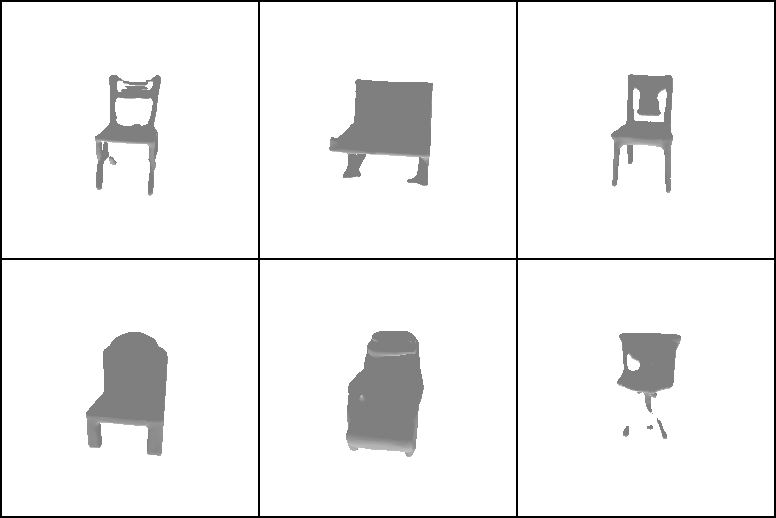

 20%|█████████████▏                                                   | 13/64 [01:33<06:03,  7.12s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/13-modelV5.gif


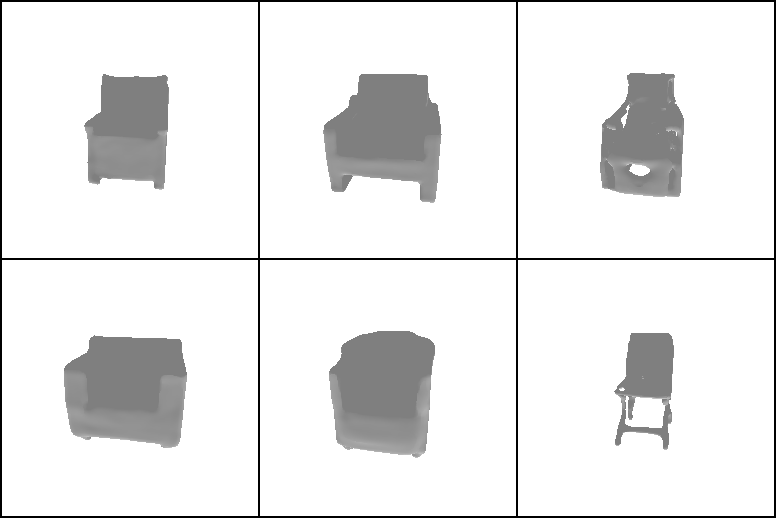

 22%|██████████████▏                                                  | 14/64 [01:40<05:57,  7.14s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/14-modelV5.gif


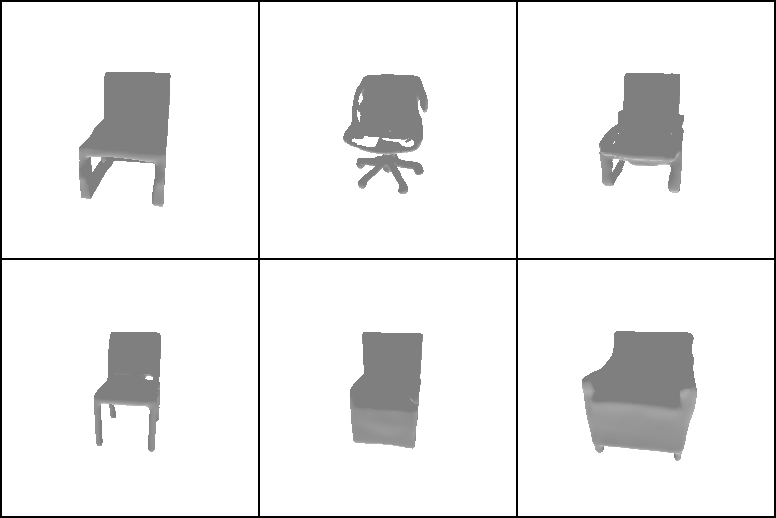

 23%|███████████████▏                                                 | 15/64 [01:47<05:50,  7.15s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/15-modelV5.gif


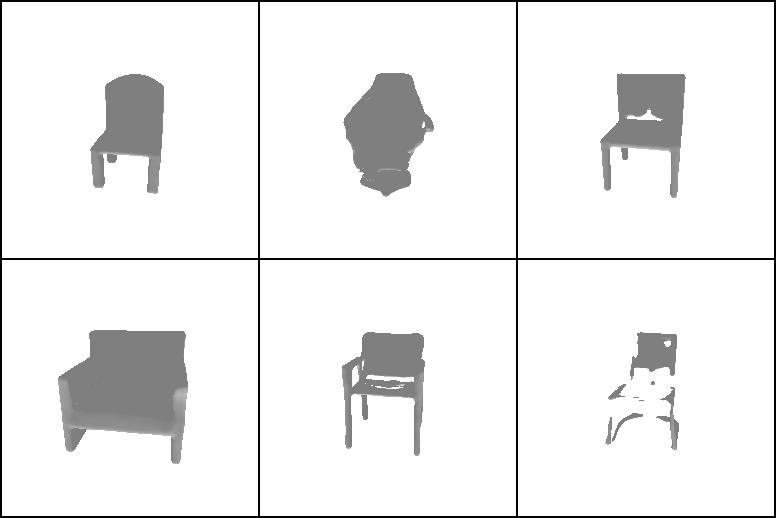

 25%|████████████████▎                                                | 16/64 [01:54<05:43,  7.15s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/16-modelV5.gif


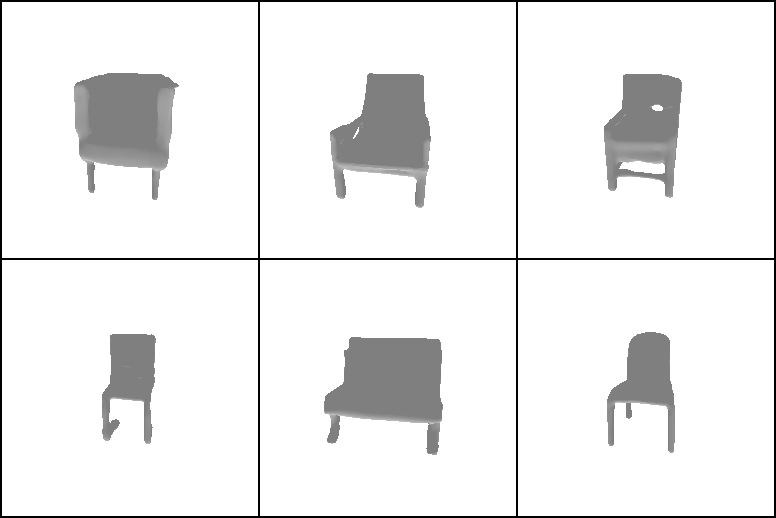

 27%|█████████████████▎                                               | 17/64 [02:01<05:36,  7.16s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/17-modelV5.gif


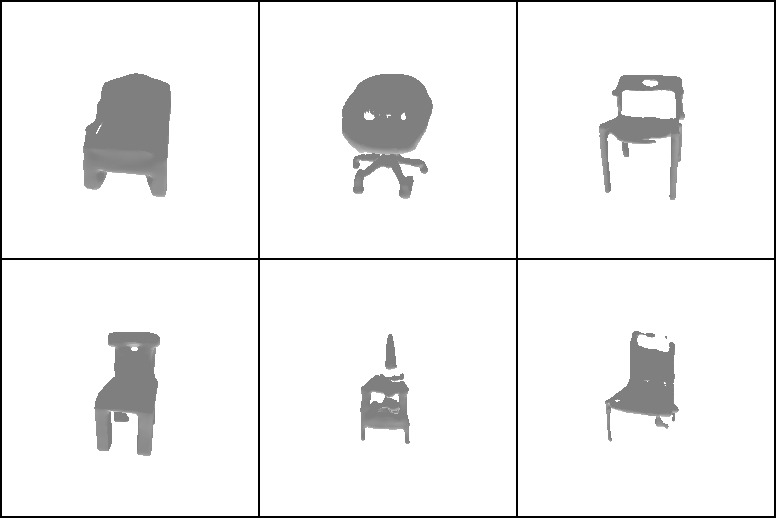

 28%|██████████████████▎                                              | 18/64 [02:09<05:29,  7.16s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/18-modelV5.gif


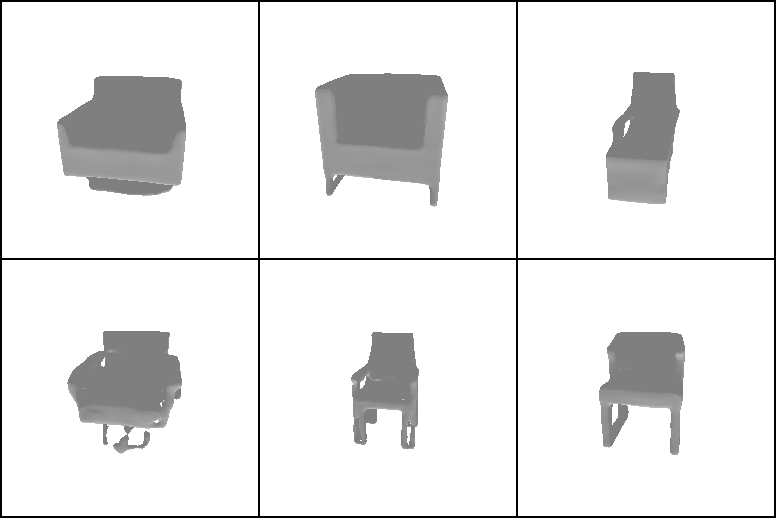

 30%|███████████████████▎                                             | 19/64 [02:16<05:22,  7.17s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/19-modelV5.gif


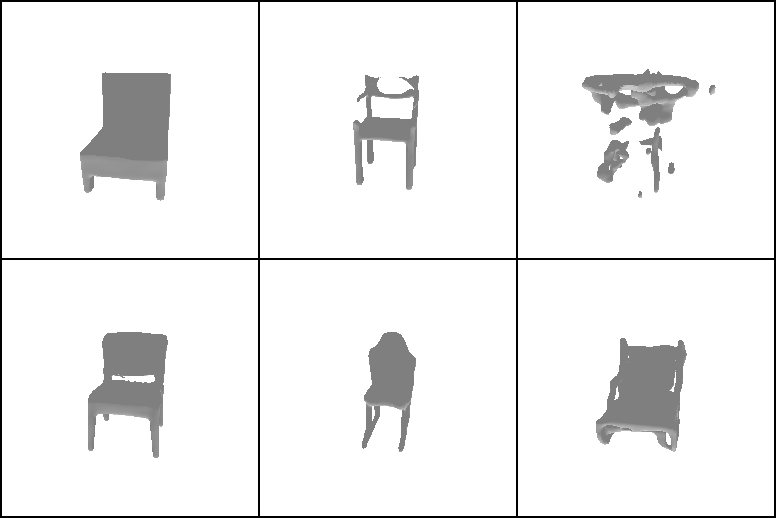

 31%|████████████████████▎                                            | 20/64 [02:23<05:14,  7.16s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/20-modelV5.gif


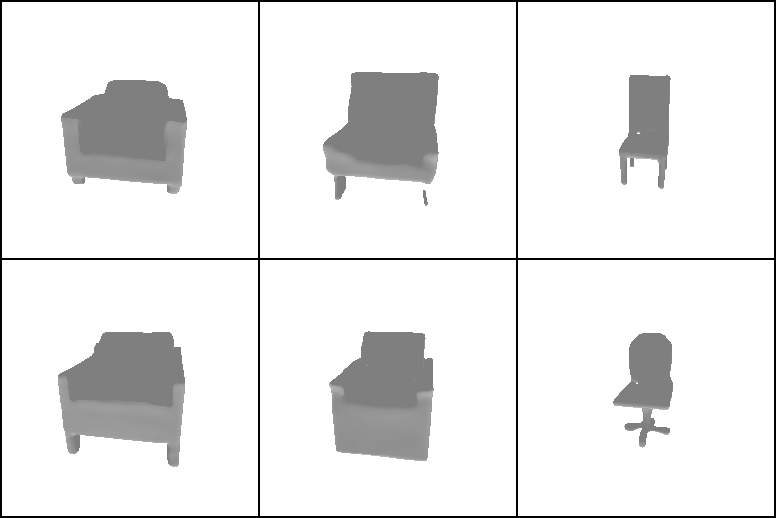

 33%|█████████████████████▎                                           | 21/64 [02:30<05:07,  7.15s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/21-modelV5.gif


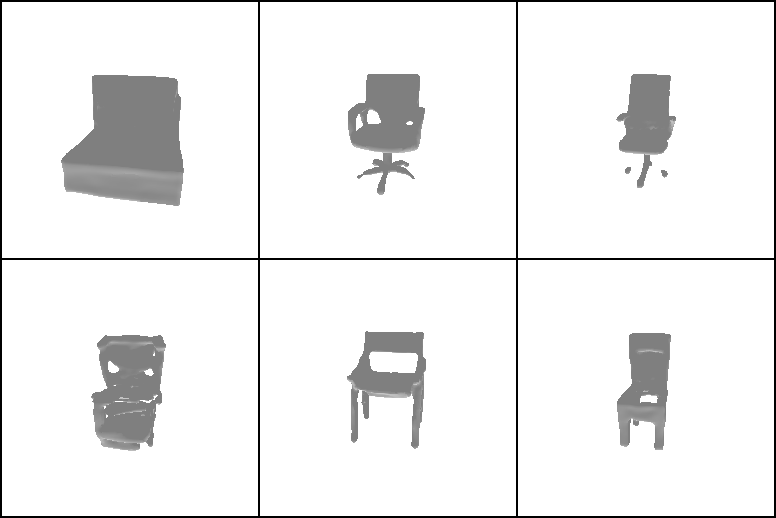

 34%|██████████████████████▎                                          | 22/64 [02:37<05:00,  7.16s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/22-modelV5.gif


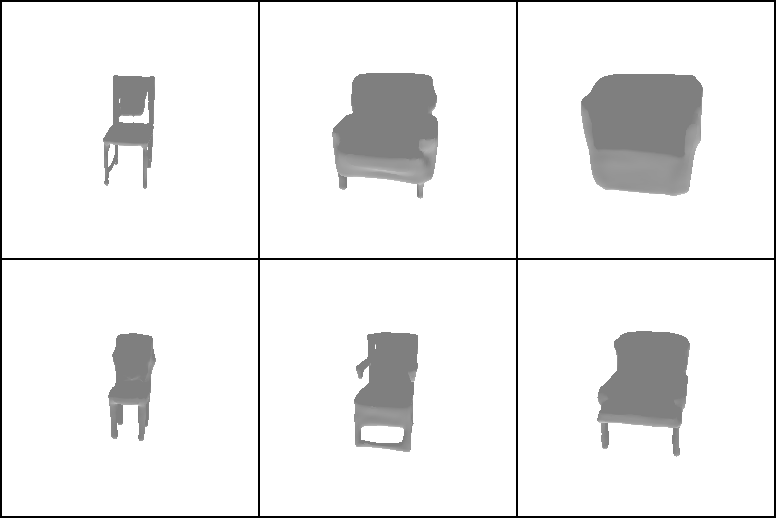

 36%|███████████████████████▎                                         | 23/64 [02:44<04:52,  7.14s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/23-modelV5.gif


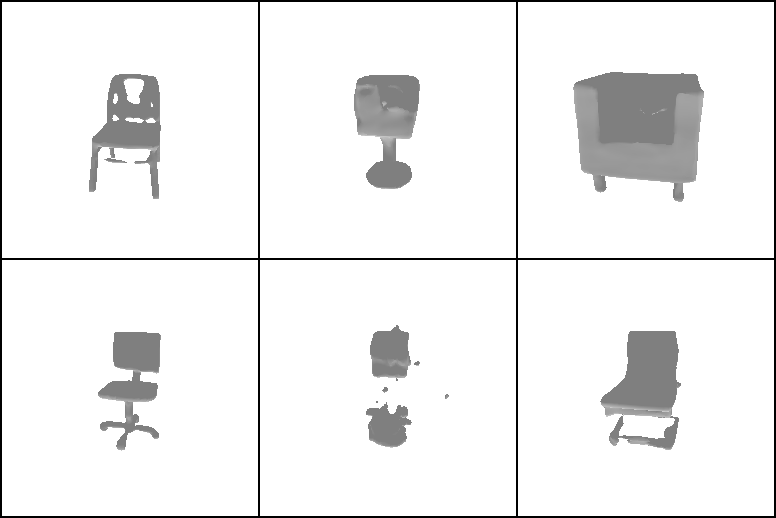

 38%|████████████████████████▍                                        | 24/64 [02:51<04:45,  7.13s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/24-modelV5.gif


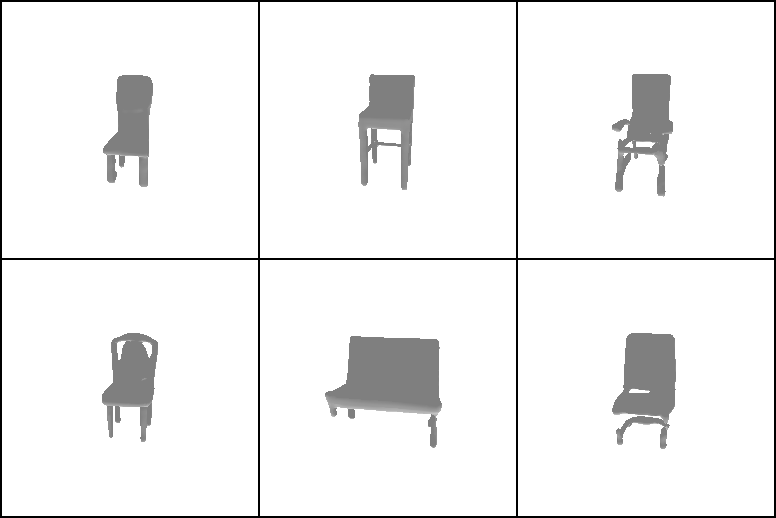

 39%|█████████████████████████▍                                       | 25/64 [02:59<04:37,  7.12s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/25-modelV5.gif


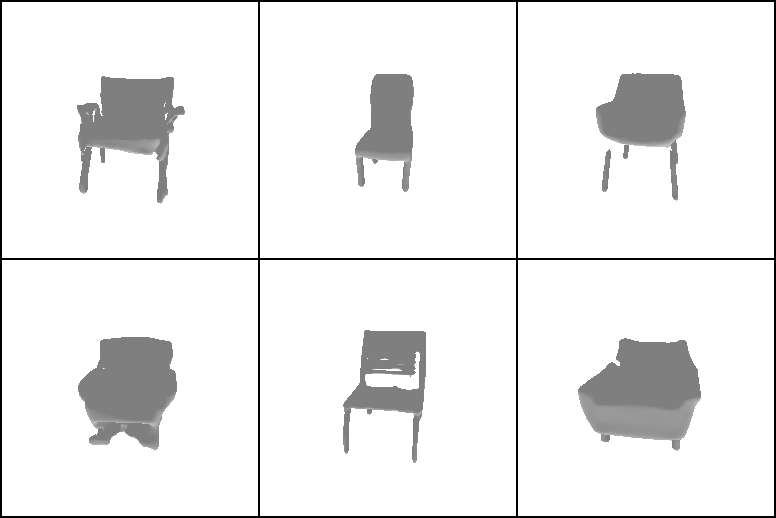

 41%|██████████████████████████▍                                      | 26/64 [03:06<04:31,  7.13s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/26-modelV5.gif


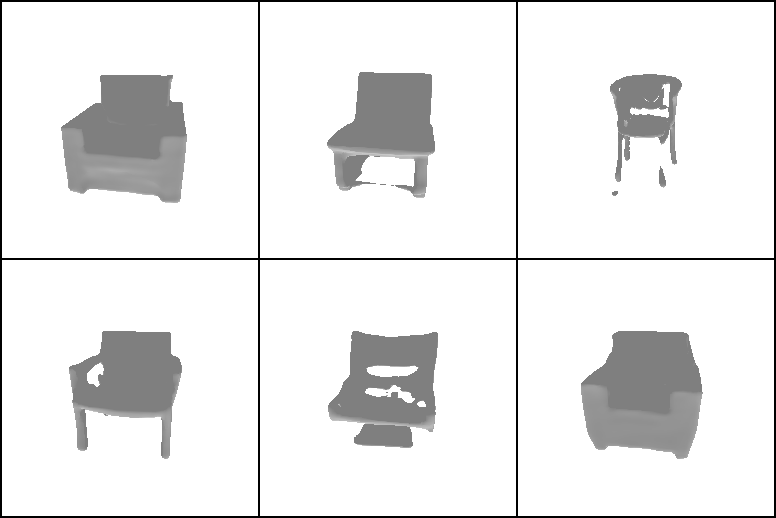

 42%|███████████████████████████▍                                     | 27/64 [03:13<04:24,  7.15s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/27-modelV5.gif


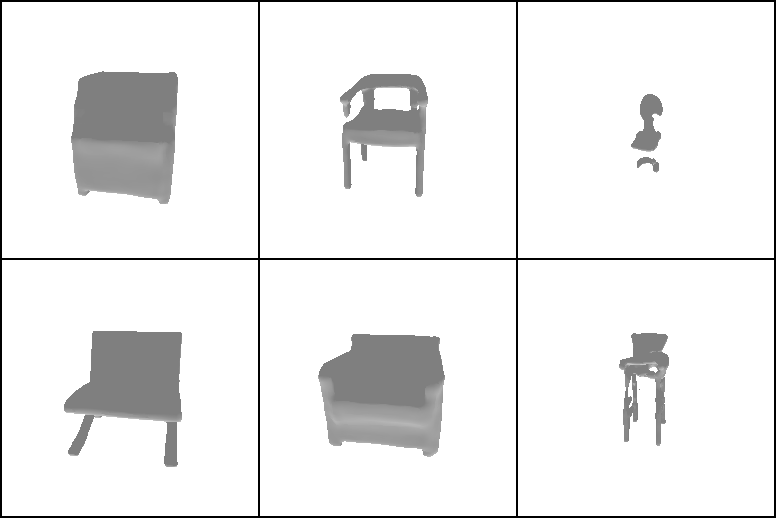

 44%|████████████████████████████▍                                    | 28/64 [03:20<04:16,  7.14s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/28-modelV5.gif


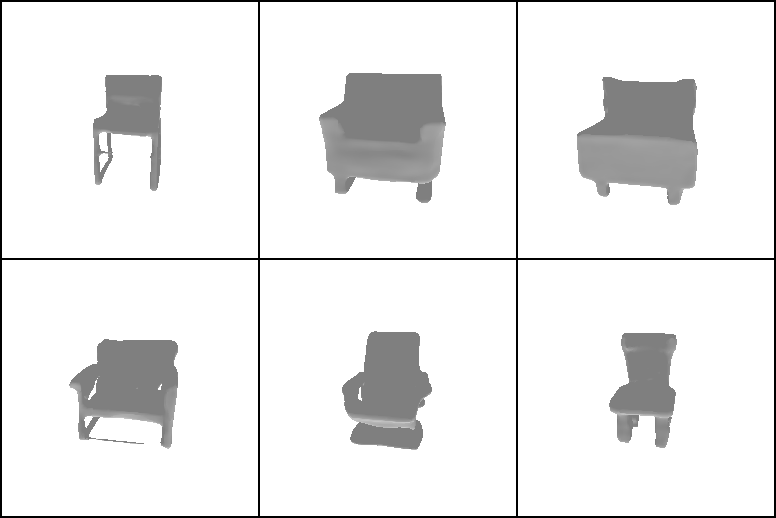

 45%|█████████████████████████████▍                                   | 29/64 [03:27<04:09,  7.13s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/29-modelV5.gif


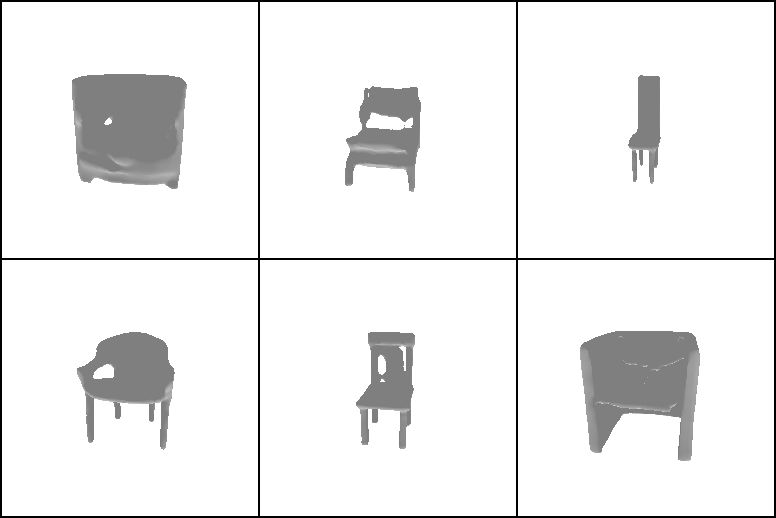

 47%|██████████████████████████████▍                                  | 30/64 [03:34<04:03,  7.15s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/30-modelV5.gif


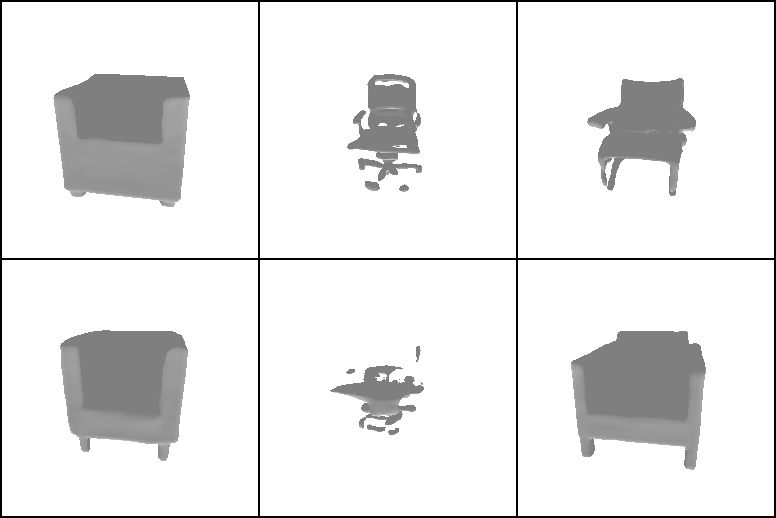

 48%|███████████████████████████████▍                                 | 31/64 [03:41<03:55,  7.15s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/31-modelV5.gif


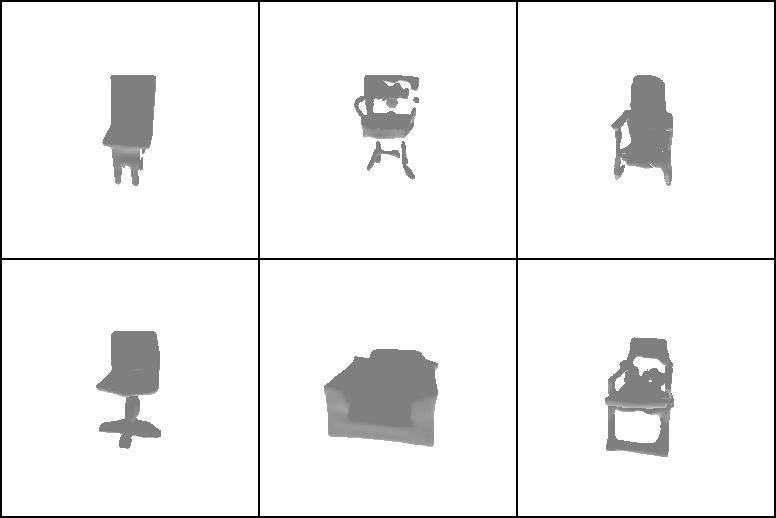

 50%|████████████████████████████████▌                                | 32/64 [03:49<03:48,  7.15s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/32-modelV5.gif


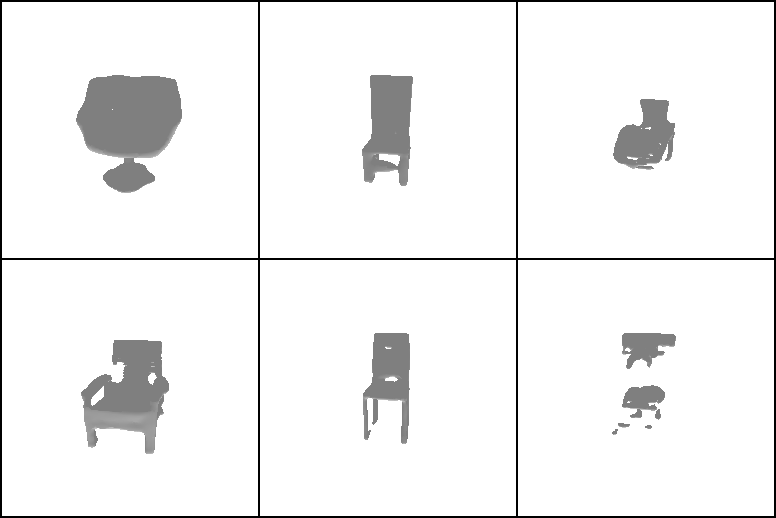

 52%|█████████████████████████████████▌                               | 33/64 [03:56<03:42,  7.18s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/33-modelV5.gif


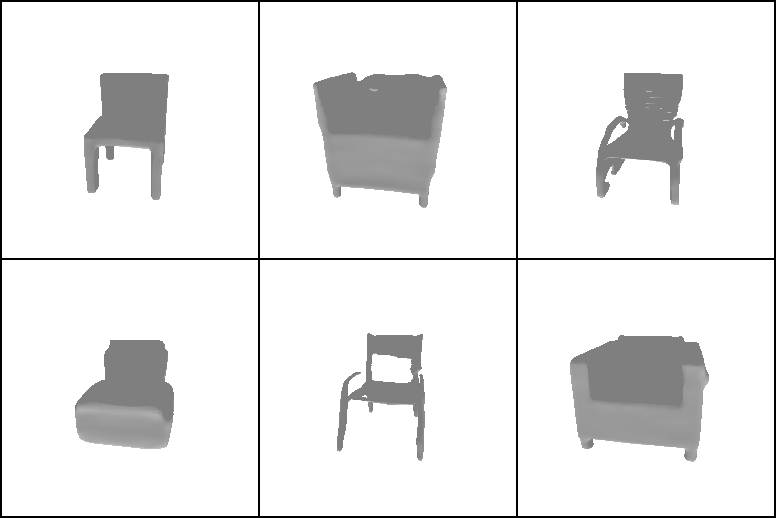

 53%|██████████████████████████████████▌                              | 34/64 [04:03<03:35,  7.17s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/34-modelV5.gif


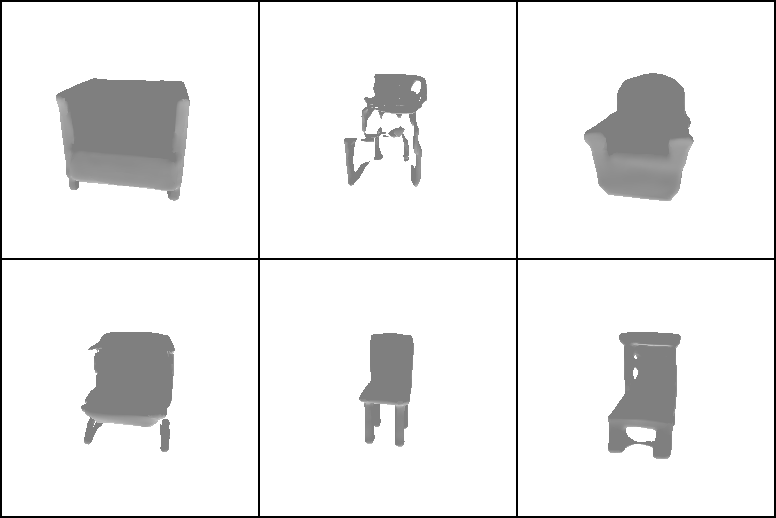

 55%|███████████████████████████████████▌                             | 35/64 [04:10<03:27,  7.17s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/35-modelV5.gif


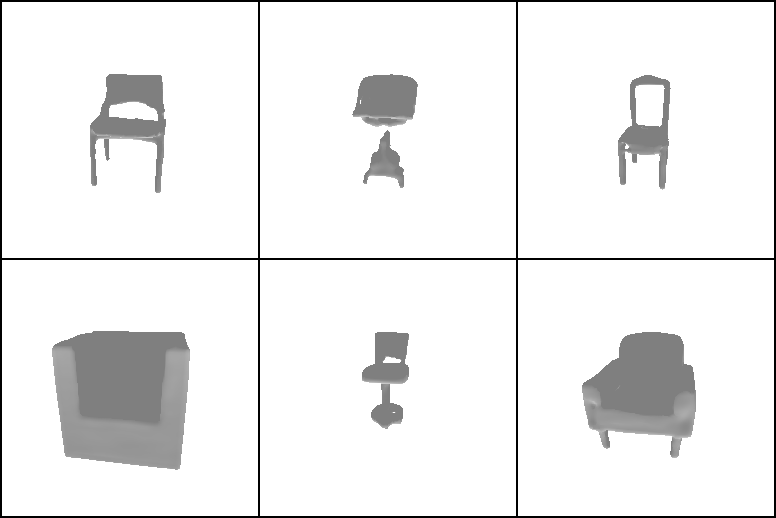

 56%|████████████████████████████████████▌                            | 36/64 [04:17<03:20,  7.15s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/36-modelV5.gif


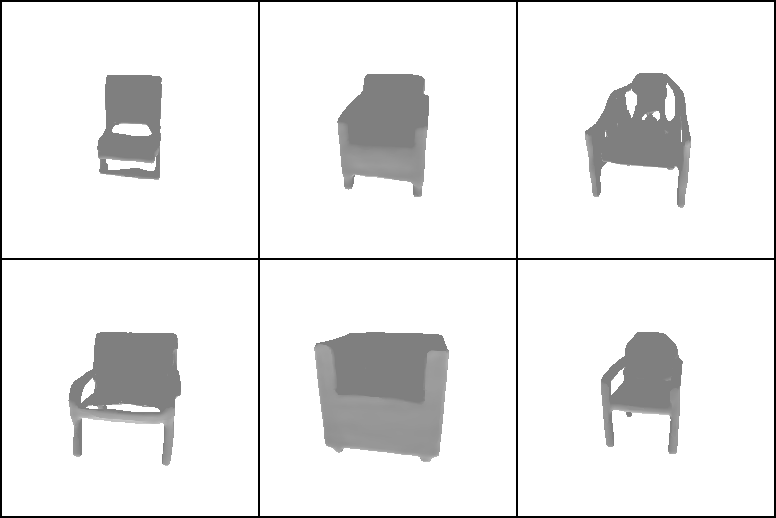

 58%|█████████████████████████████████████▌                           | 37/64 [04:24<03:13,  7.15s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/37-modelV5.gif


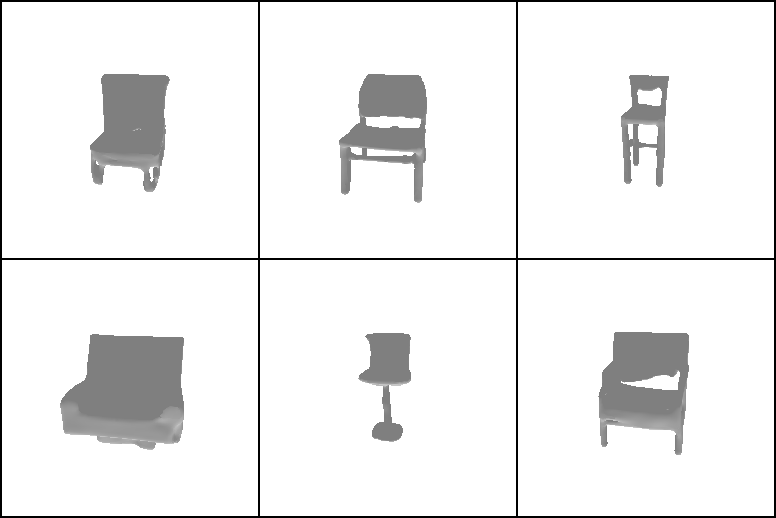

 59%|██████████████████████████████████████▌                          | 38/64 [04:32<03:05,  7.15s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/38-modelV5.gif


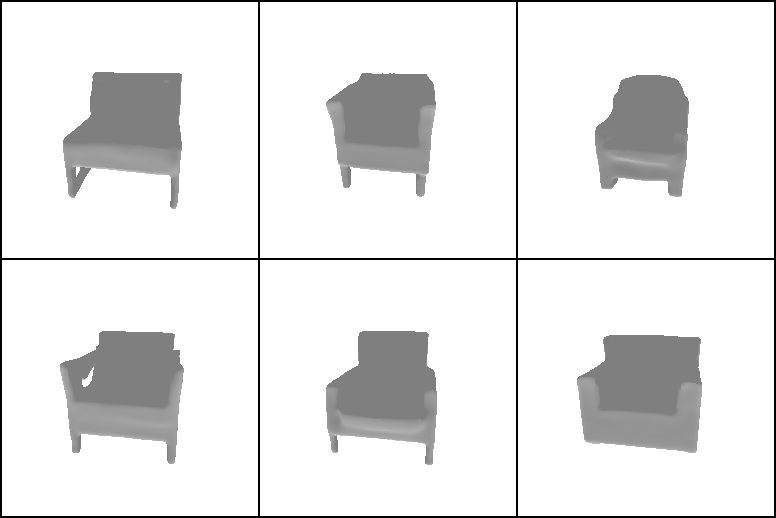

 61%|███████████████████████████████████████▌                         | 39/64 [04:39<02:59,  7.16s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/39-modelV5.gif


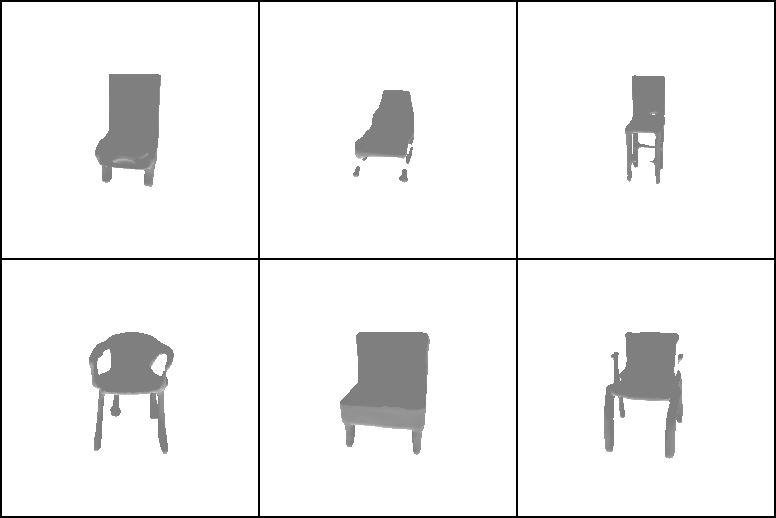

 62%|████████████████████████████████████████▋                        | 40/64 [04:46<02:51,  7.16s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/40-modelV5.gif


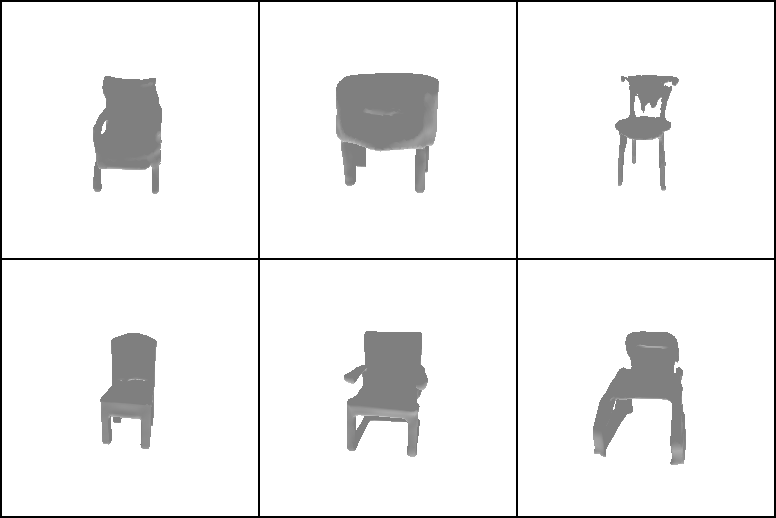

 64%|█████████████████████████████████████████▋                       | 41/64 [04:53<02:44,  7.16s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/41-modelV5.gif


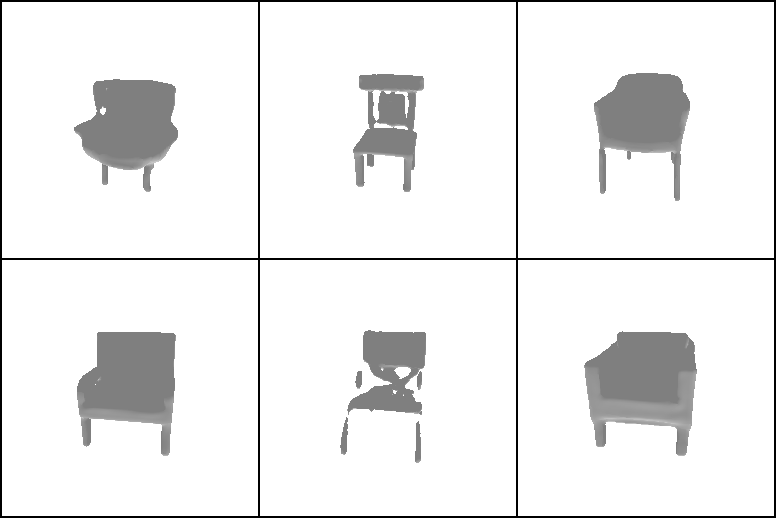

 66%|██████████████████████████████████████████▋                      | 42/64 [05:00<02:37,  7.17s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/42-modelV5.gif


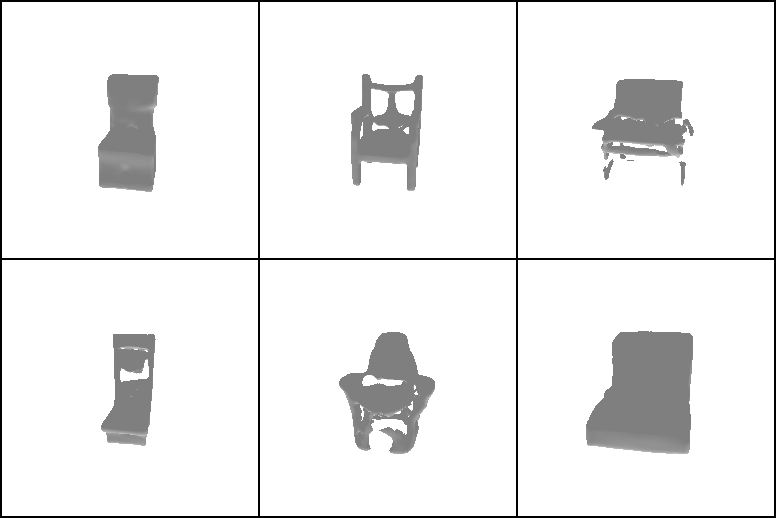

 67%|███████████████████████████████████████████▋                     | 43/64 [05:07<02:30,  7.15s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/43-modelV5.gif


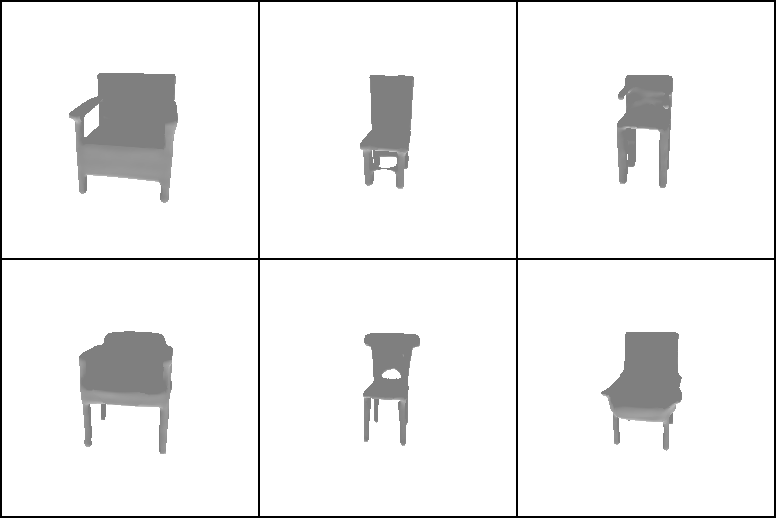

 69%|████████████████████████████████████████████▋                    | 44/64 [05:15<02:23,  7.18s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/44-modelV5.gif


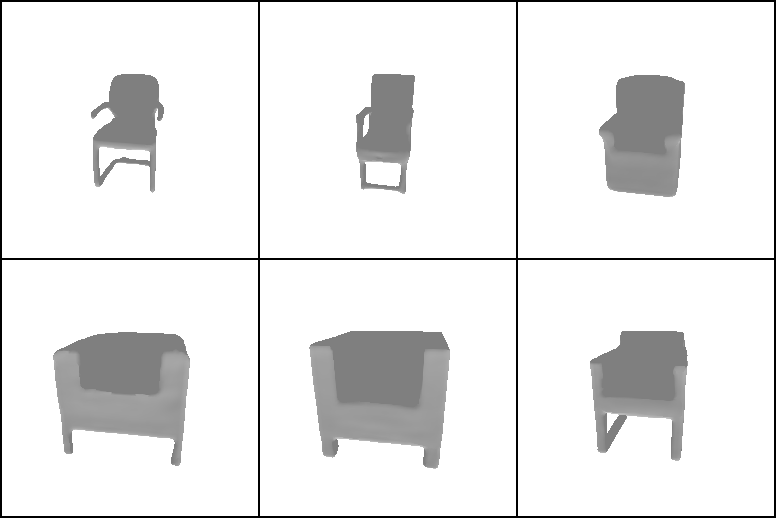

 70%|█████████████████████████████████████████████▋                   | 45/64 [05:22<02:16,  7.21s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/45-modelV5.gif


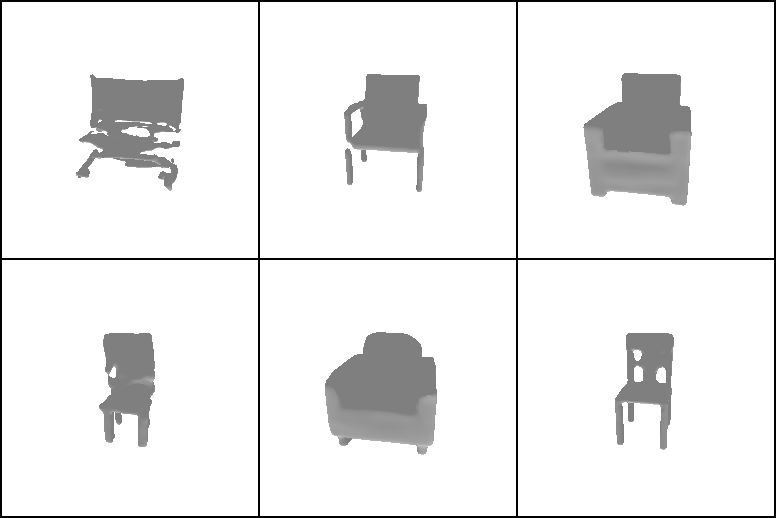

 72%|██████████████████████████████████████████████▋                  | 46/64 [05:29<02:09,  7.20s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/46-modelV5.gif


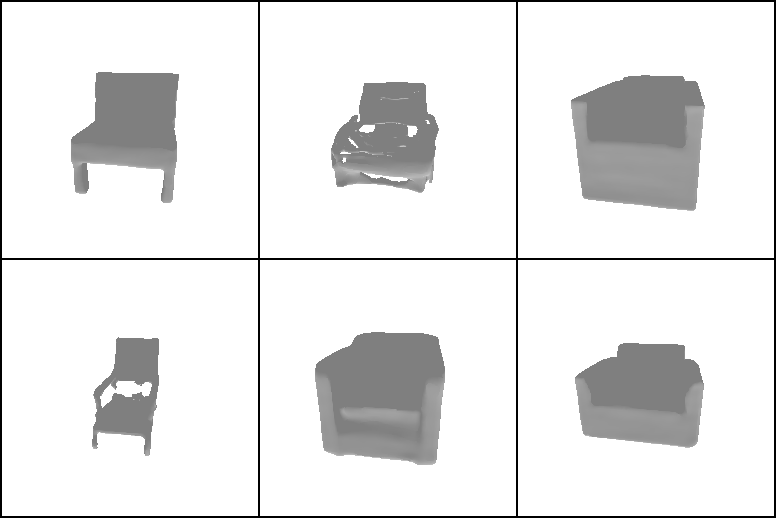

 73%|███████████████████████████████████████████████▋                 | 47/64 [05:36<02:02,  7.20s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/47-modelV5.gif


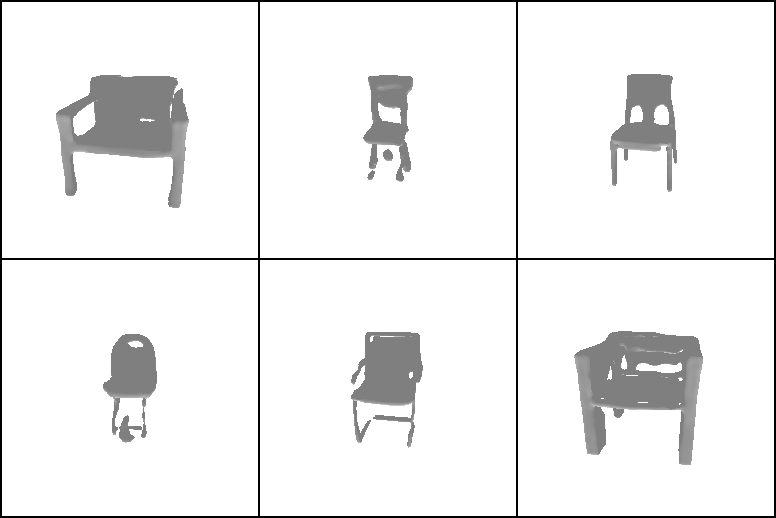

 75%|████████████████████████████████████████████████▊                | 48/64 [05:43<01:55,  7.19s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/48-modelV5.gif


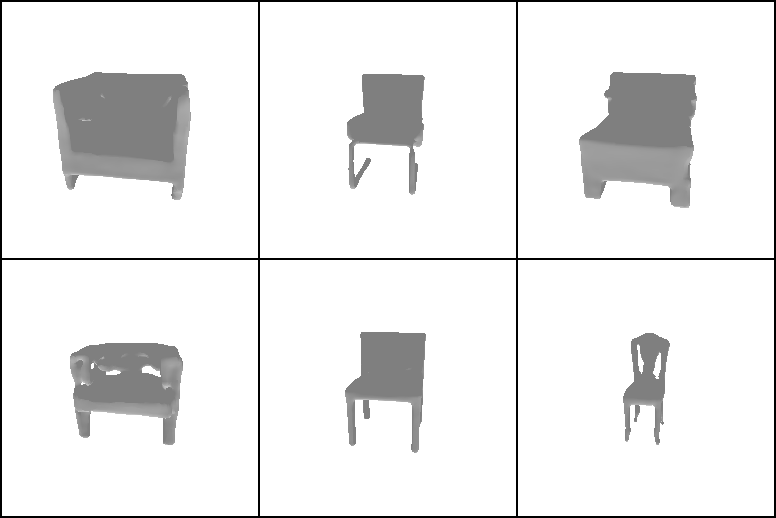

 77%|█████████████████████████████████████████████████▊               | 49/64 [05:51<01:47,  7.19s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/49-modelV5.gif


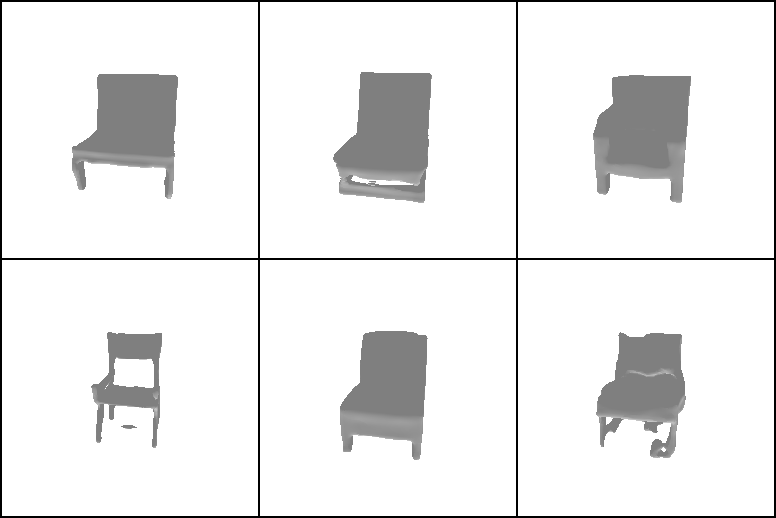

 78%|██████████████████████████████████████████████████▊              | 50/64 [05:58<01:40,  7.18s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/50-modelV5.gif


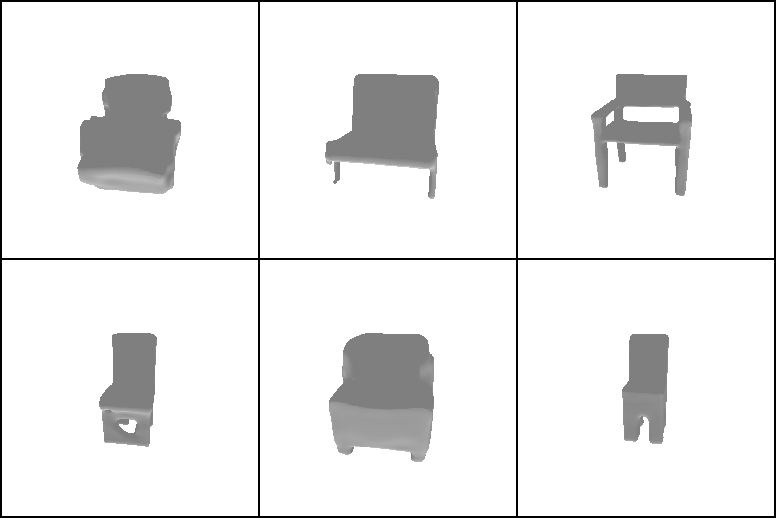

 80%|███████████████████████████████████████████████████▊             | 51/64 [06:05<01:33,  7.17s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/51-modelV5.gif


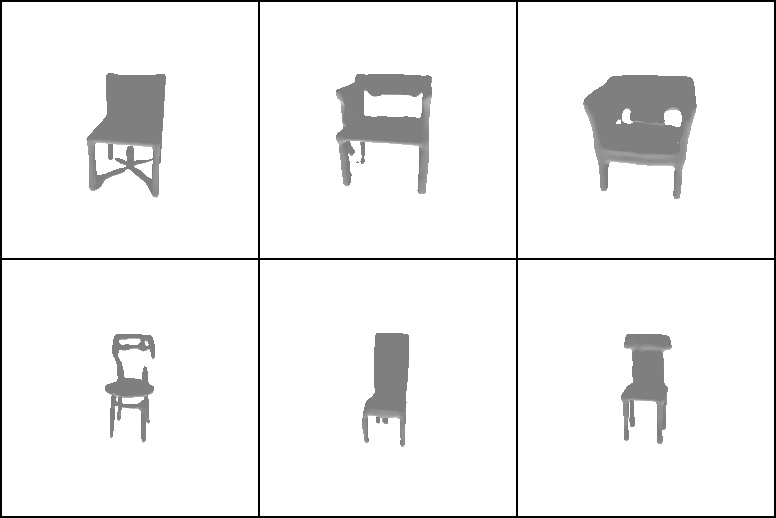

 81%|████████████████████████████████████████████████████▊            | 52/64 [06:12<01:26,  7.17s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/52-modelV5.gif


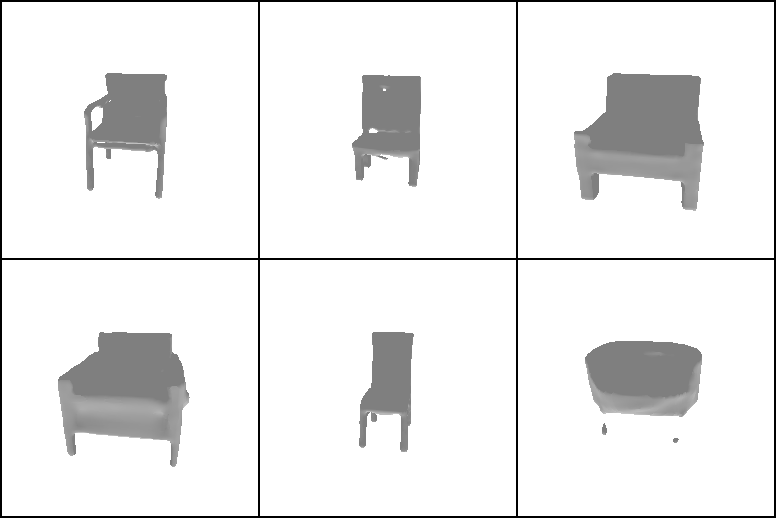

 83%|█████████████████████████████████████████████████████▊           | 53/64 [06:19<01:19,  7.19s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/53-modelV5.gif


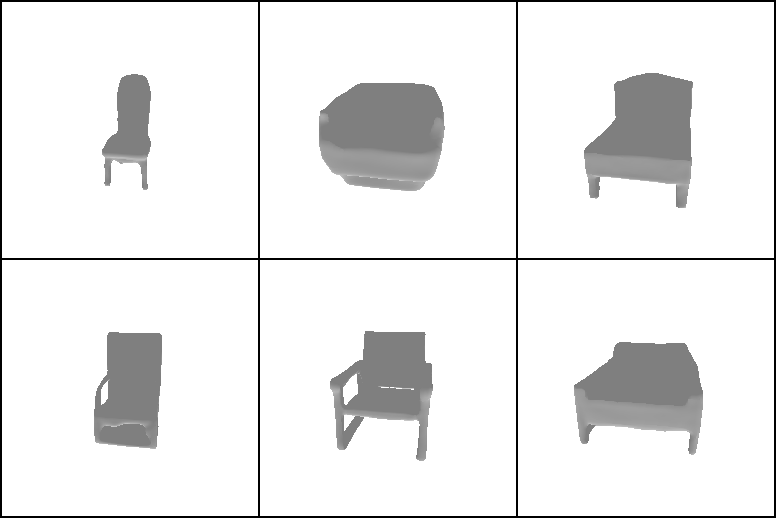

 84%|██████████████████████████████████████████████████████▊          | 54/64 [06:26<01:11,  7.17s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/54-modelV5.gif


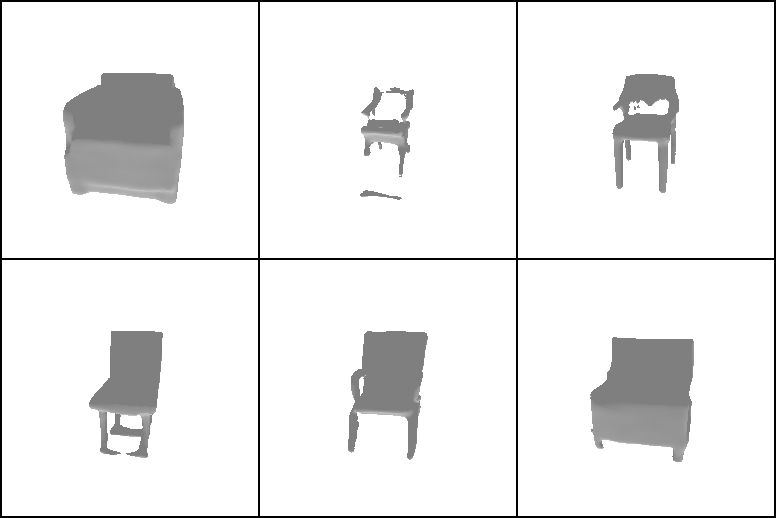

 86%|███████████████████████████████████████████████████████▊         | 55/64 [06:34<01:04,  7.17s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/55-modelV5.gif


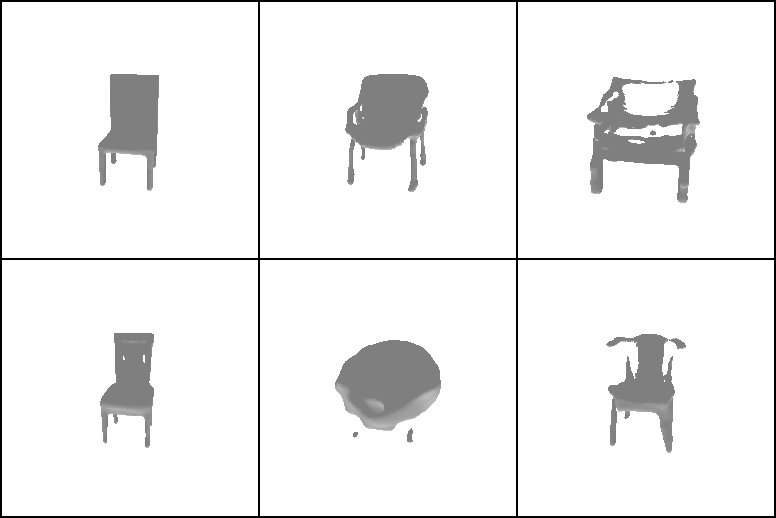

 88%|████████████████████████████████████████████████████████▉        | 56/64 [06:41<00:57,  7.14s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/56-modelV5.gif


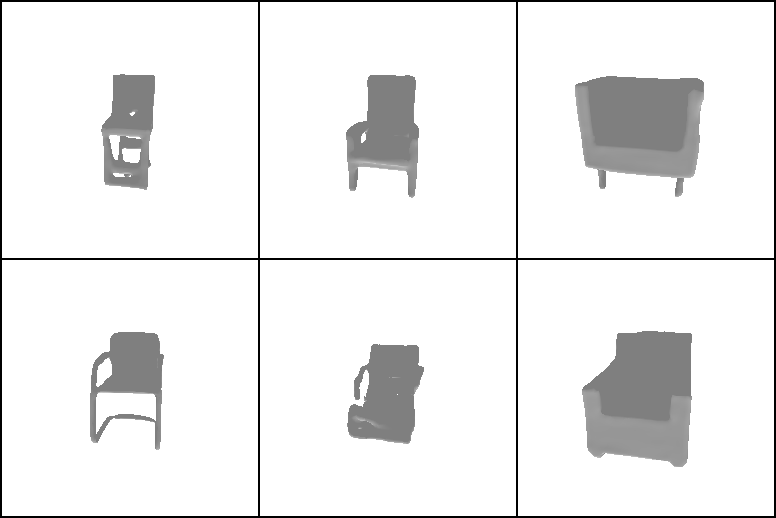

 89%|█████████████████████████████████████████████████████████▉       | 57/64 [06:48<00:50,  7.15s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/57-modelV5.gif


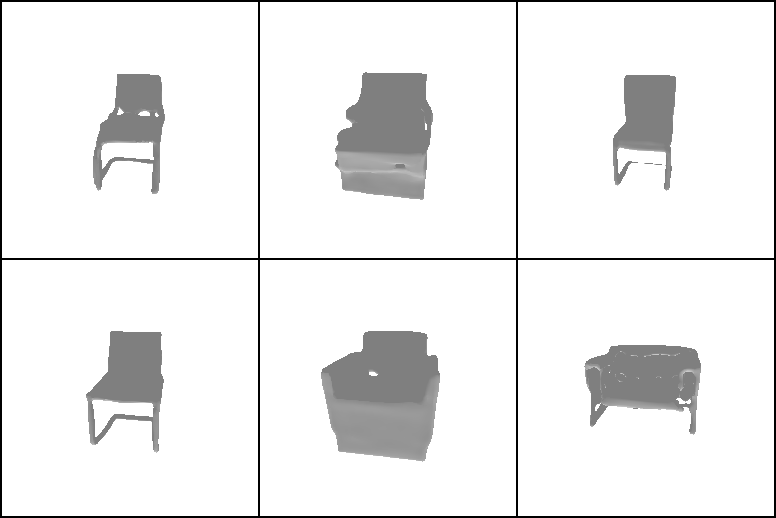

 91%|██████████████████████████████████████████████████████████▉      | 58/64 [06:55<00:42,  7.15s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/58-modelV5.gif


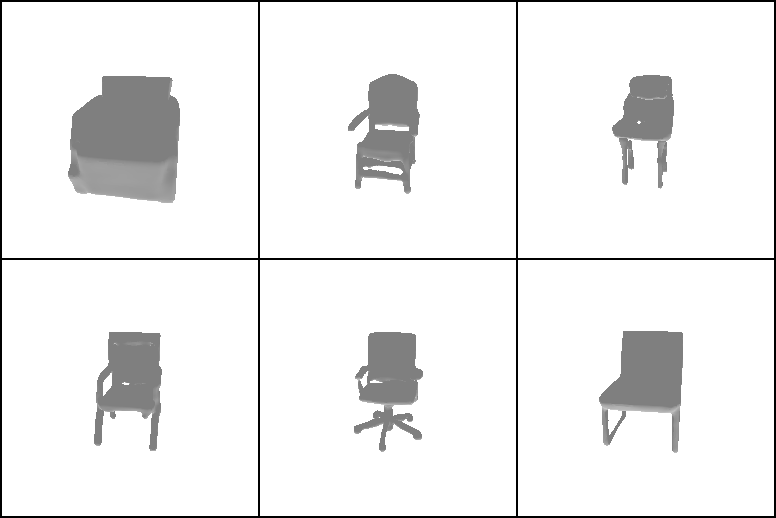

 92%|███████████████████████████████████████████████████████████▉     | 59/64 [07:02<00:35,  7.18s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/59-modelV5.gif


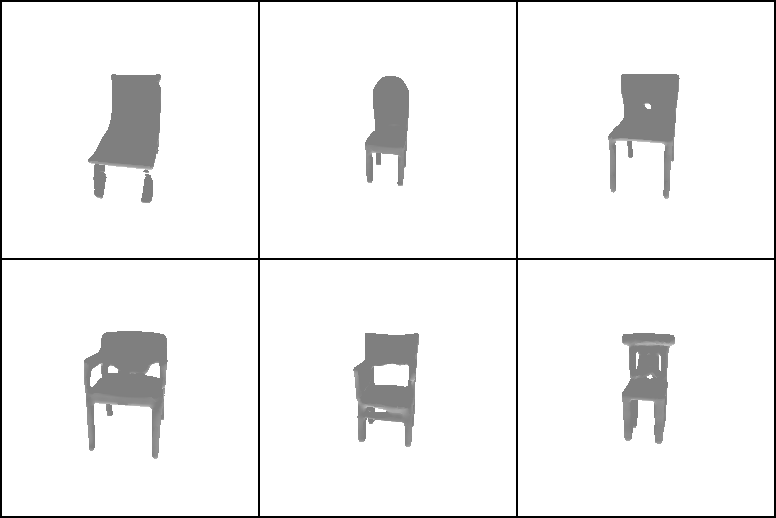

 94%|████████████████████████████████████████████████████████████▉    | 60/64 [07:09<00:28,  7.16s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/60-modelV5.gif


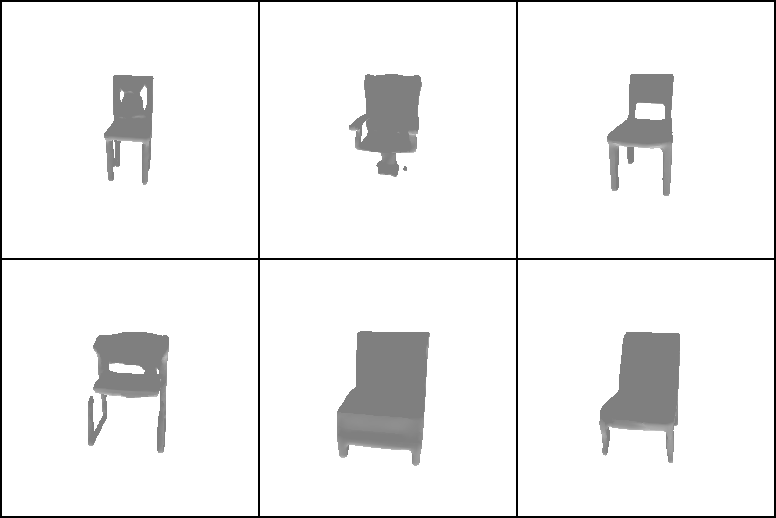

 95%|█████████████████████████████████████████████████████████████▉   | 61/64 [07:16<00:21,  7.14s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/61-modelV5.gif


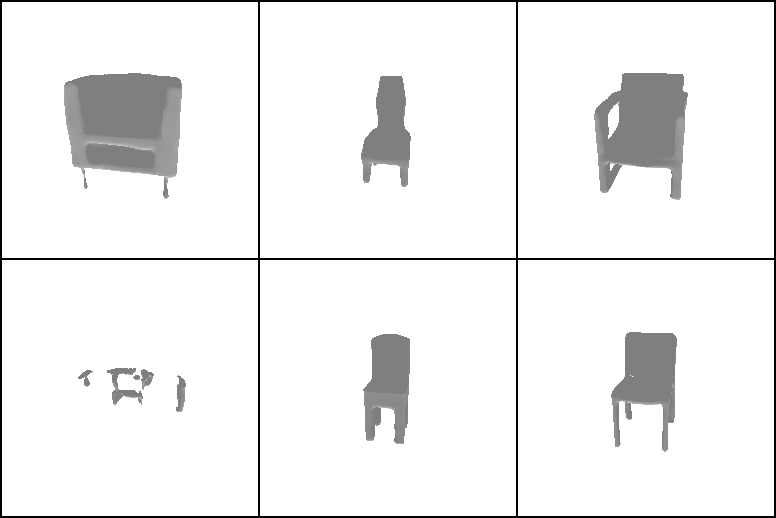

 97%|██████████████████████████████████████████████████████████████▉  | 62/64 [07:24<00:14,  7.14s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/62-modelV5.gif


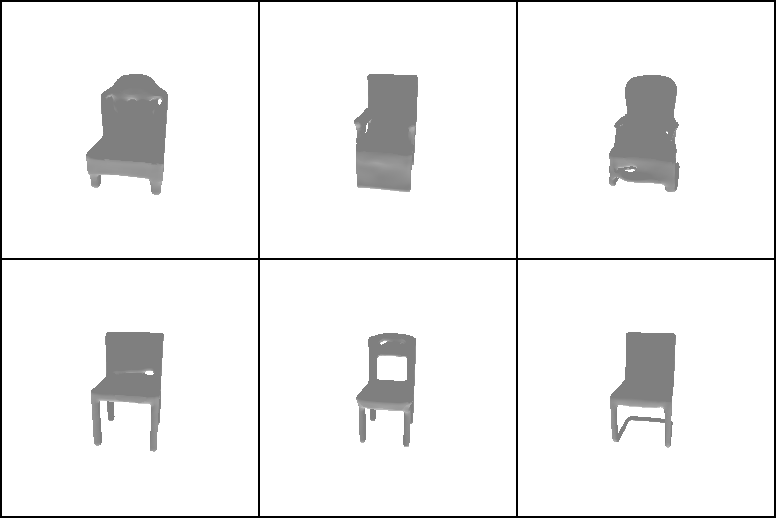

 98%|███████████████████████████████████████████████████████████████▉ | 63/64 [07:31<00:07,  7.14s/it]

[*] autoregressively inferencing...:   0%|          | 0/512 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/unconditional/63-modelV5.gif


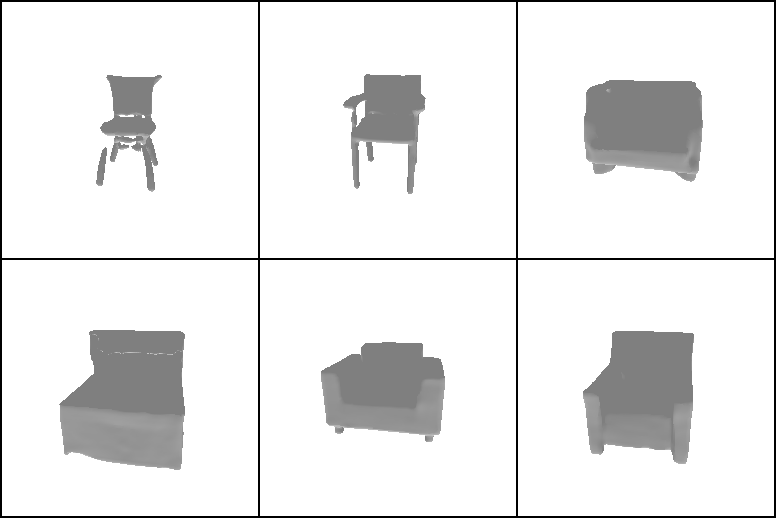

100%|█████████████████████████████████████████████████████████████████| 64/64 [07:38<00:00,  7.16s/it]


In [33]:
import torch
from utils.qual_util import get_lang_prob_recursive, save_mesh_as_pics
from einops import rearrange


gpu_id = 0
#nimgs=3

class Opt:
    def __init__(self):
        self.name = 'opt'


model = modelV5
model_name = "modelV5"
#bert2vq = bert2vqV3



nimgs=6
for j in tqdm(range(len(dataset))):
    data = dataset[j]
    #import pdb;pdb.set_trace()
    z1 = data["z_set_target"].unsqueeze(0).cuda()
    test_data = { }
    sampler = torch.distributions.categorical.Categorical(z1)
    codeix = sampler.sample()
    #z1  = z1.repeat_interleave(nimgs, dim=0)
    z1 = torch.full((nimgs,8,8,8,512), 1/512)
    test_data["z_set"] = z1 
        #test_data["z_set"] = shapeset[4]["z_set"].unsqueeze(0).repeat_interleave(nimgs, dim=0)
    #test_data["idx"] = sampler.sample().repeat_interleave(nimgs, axis=0).cpu()
    test_data["idx"] = torch.full((nimgs,8,8,8), 0)
    model.inference(test_data, topk=30, prob=None, gen_order=None)
    gen_mesh = sdf_to_mesh(model.x_recon_tf)
    gen_gif_name = f'{res_dir}/{j}-{model_name}.gif'
    try:
        save_mesh_as_pics(mesh_renderer, gen_mesh, nrow=3, out_name=gen_gif_name)
        print("Saved:", gen_gif_name)
    except:
        import pdb;pdb.set_trace()
           
    for name in [gen_gif_name]:
        display(ipy_image(name))

  0%|                                                                          | 0/64 [00:00<?, ?it/s]

Saved: logs/transformer-sanity/labels/0-z_set.gif
Saved: logs/transformer-sanity/labels/0-z_shape.gif


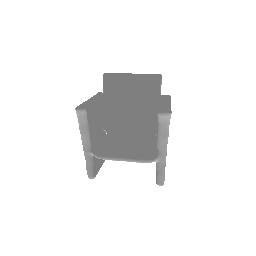

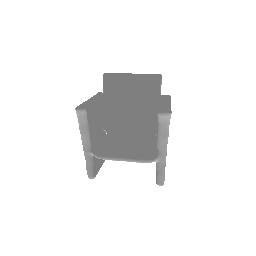

  2%|█                                                                 | 1/64 [00:00<00:39,  1.58it/s]

Saved: logs/transformer-sanity/labels/1-z_set.gif
Saved: logs/transformer-sanity/labels/1-z_shape.gif


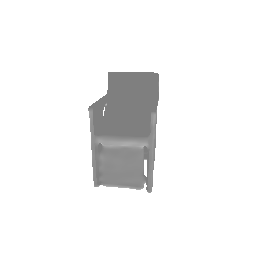

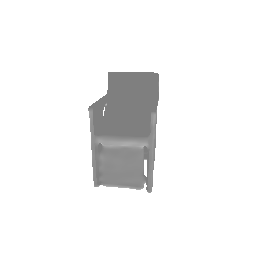

  3%|██                                                                | 2/64 [00:01<00:38,  1.60it/s]

Saved: logs/transformer-sanity/labels/2-z_set.gif
Saved: logs/transformer-sanity/labels/2-z_shape.gif


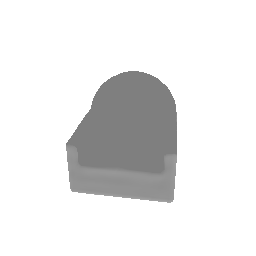

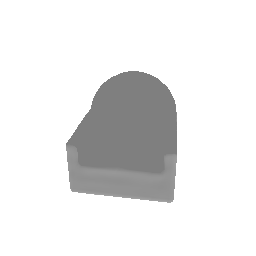

  5%|███                                                               | 3/64 [00:01<00:37,  1.63it/s]

Saved: logs/transformer-sanity/labels/3-z_set.gif
Saved: logs/transformer-sanity/labels/3-z_shape.gif


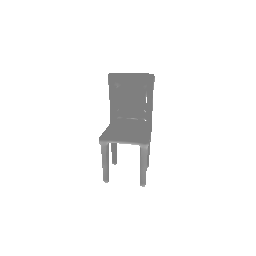

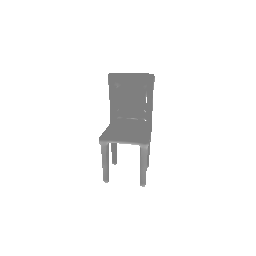

  6%|████▏                                                             | 4/64 [00:02<00:36,  1.65it/s]

Saved: logs/transformer-sanity/labels/4-z_set.gif
Saved: logs/transformer-sanity/labels/4-z_shape.gif


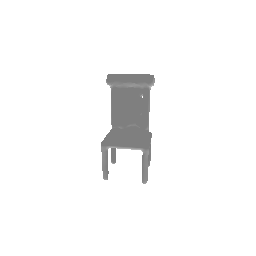

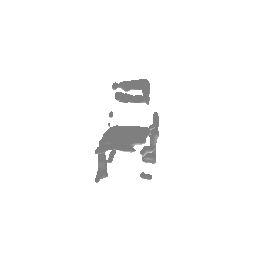

  8%|█████▏                                                            | 5/64 [00:03<00:35,  1.65it/s]

Saved: logs/transformer-sanity/labels/5-z_set.gif
Saved: logs/transformer-sanity/labels/5-z_shape.gif


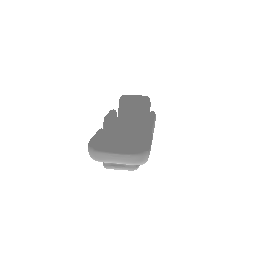

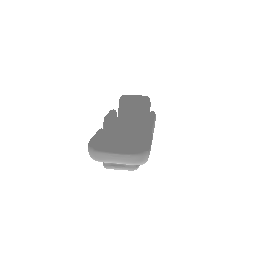

  9%|██████▏                                                           | 6/64 [00:03<00:34,  1.66it/s]

Saved: logs/transformer-sanity/labels/6-z_set.gif
Saved: logs/transformer-sanity/labels/6-z_shape.gif


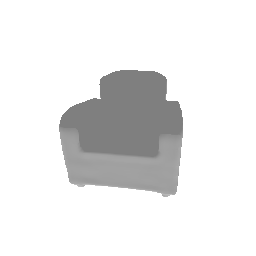

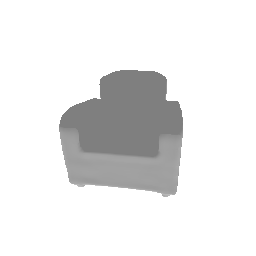

 11%|███████▏                                                          | 7/64 [00:04<00:34,  1.65it/s]

Saved: logs/transformer-sanity/labels/7-z_set.gif
Saved: logs/transformer-sanity/labels/7-z_shape.gif


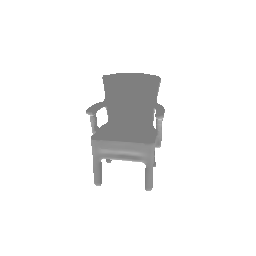

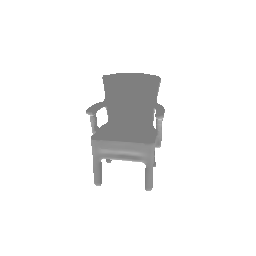

 12%|████████▎                                                         | 8/64 [00:04<00:33,  1.65it/s]

Saved: logs/transformer-sanity/labels/8-z_set.gif
Saved: logs/transformer-sanity/labels/8-z_shape.gif


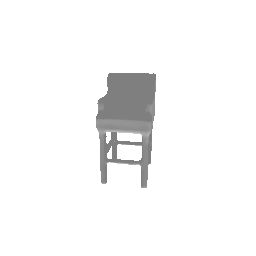

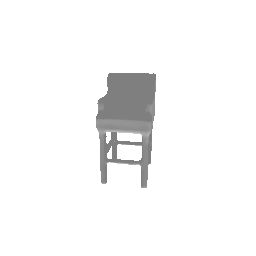

 14%|█████████▎                                                        | 9/64 [00:05<00:33,  1.67it/s]

Saved: logs/transformer-sanity/labels/9-z_set.gif
Saved: logs/transformer-sanity/labels/9-z_shape.gif


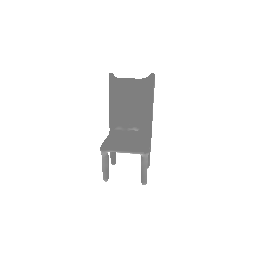

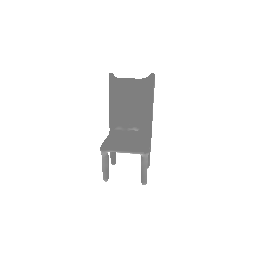

 16%|██████████▏                                                      | 10/64 [00:06<00:32,  1.67it/s]

Saved: logs/transformer-sanity/labels/10-z_set.gif
Saved: logs/transformer-sanity/labels/10-z_shape.gif


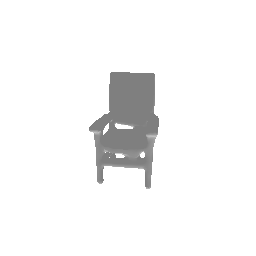

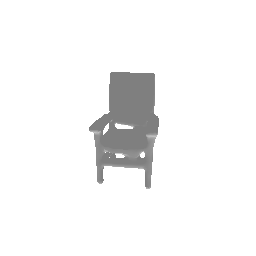

 17%|███████████▏                                                     | 11/64 [00:06<00:32,  1.65it/s]

Saved: logs/transformer-sanity/labels/11-z_set.gif
Saved: logs/transformer-sanity/labels/11-z_shape.gif


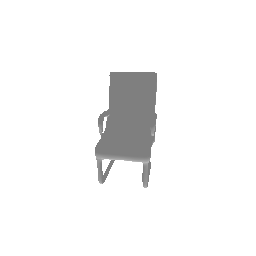

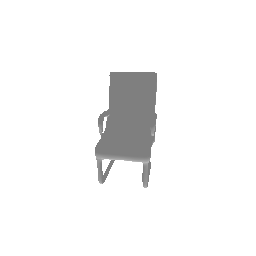

 19%|████████████▏                                                    | 12/64 [00:07<00:31,  1.65it/s]

Saved: logs/transformer-sanity/labels/12-z_set.gif
Saved: logs/transformer-sanity/labels/12-z_shape.gif


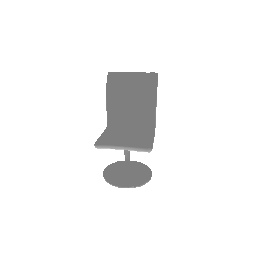

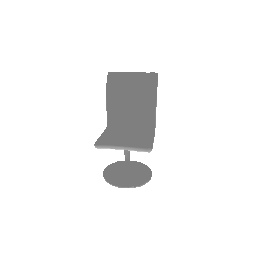

 20%|█████████████▏                                                   | 13/64 [00:07<00:30,  1.65it/s]

Saved: logs/transformer-sanity/labels/13-z_set.gif
Saved: logs/transformer-sanity/labels/13-z_shape.gif


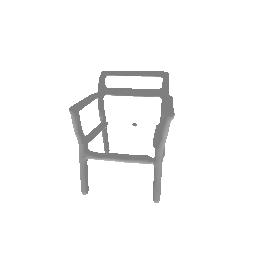

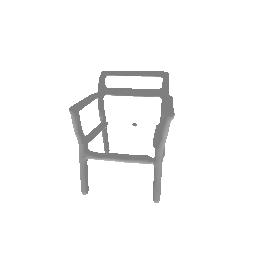

 22%|██████████████▏                                                  | 14/64 [00:08<00:30,  1.66it/s]

Saved: logs/transformer-sanity/labels/14-z_set.gif
Saved: logs/transformer-sanity/labels/14-z_shape.gif


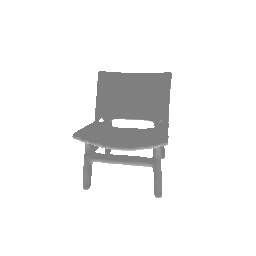

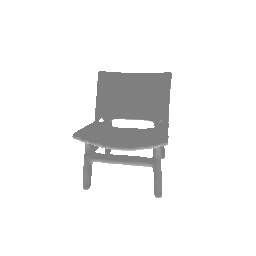

 23%|███████████████▏                                                 | 15/64 [00:09<00:29,  1.65it/s]

Saved: logs/transformer-sanity/labels/15-z_set.gif
Saved: logs/transformer-sanity/labels/15-z_shape.gif


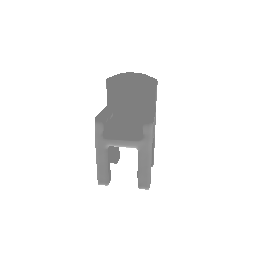

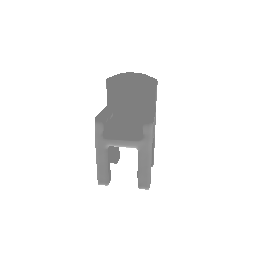

 25%|████████████████▎                                                | 16/64 [00:09<00:28,  1.66it/s]

Saved: logs/transformer-sanity/labels/16-z_set.gif
Saved: logs/transformer-sanity/labels/16-z_shape.gif


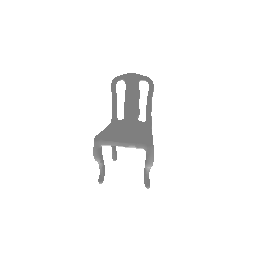

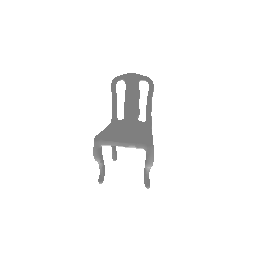

 27%|█████████████████▎                                               | 17/64 [00:10<00:28,  1.66it/s]

Saved: logs/transformer-sanity/labels/17-z_set.gif
Saved: logs/transformer-sanity/labels/17-z_shape.gif


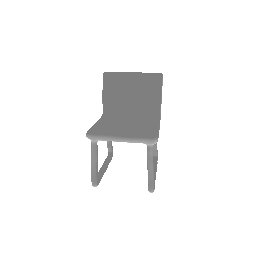

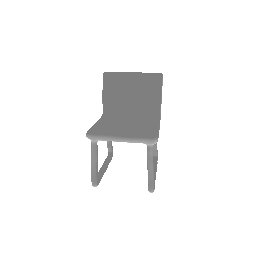

 28%|██████████████████▎                                              | 18/64 [00:10<00:27,  1.67it/s]

Saved: logs/transformer-sanity/labels/18-z_set.gif
Saved: logs/transformer-sanity/labels/18-z_shape.gif


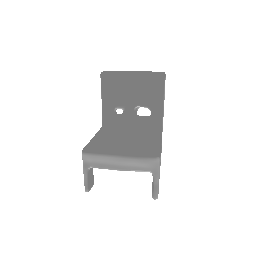

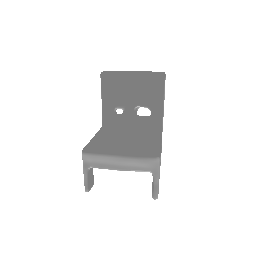

 30%|███████████████████▎                                             | 19/64 [00:11<00:27,  1.67it/s]

Saved: logs/transformer-sanity/labels/19-z_set.gif
Saved: logs/transformer-sanity/labels/19-z_shape.gif


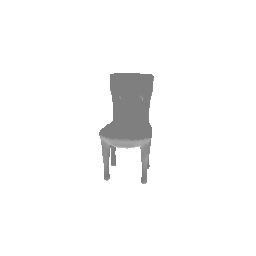

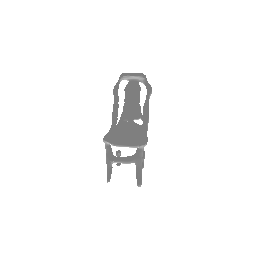

 31%|████████████████████▎                                            | 20/64 [00:12<00:26,  1.64it/s]

Saved: logs/transformer-sanity/labels/20-z_set.gif
Saved: logs/transformer-sanity/labels/20-z_shape.gif


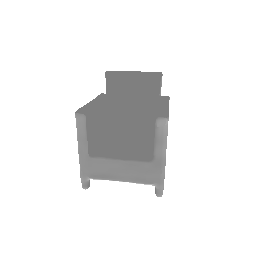

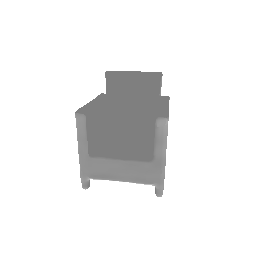

 33%|█████████████████████▎                                           | 21/64 [00:12<00:26,  1.63it/s]

Saved: logs/transformer-sanity/labels/21-z_set.gif
Saved: logs/transformer-sanity/labels/21-z_shape.gif


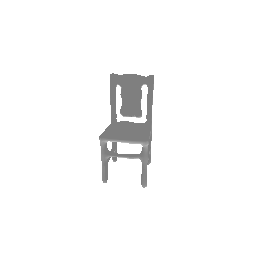

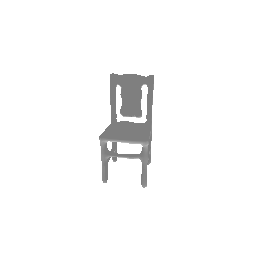

 34%|██████████████████████▎                                          | 22/64 [00:13<00:25,  1.65it/s]

Saved: logs/transformer-sanity/labels/22-z_set.gif
Saved: logs/transformer-sanity/labels/22-z_shape.gif


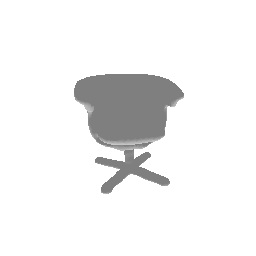

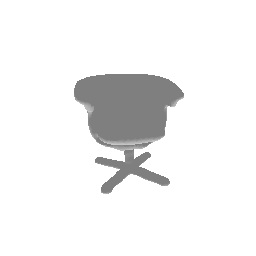

 36%|███████████████████████▎                                         | 23/64 [00:13<00:25,  1.64it/s]

Saved: logs/transformer-sanity/labels/23-z_set.gif
Saved: logs/transformer-sanity/labels/23-z_shape.gif


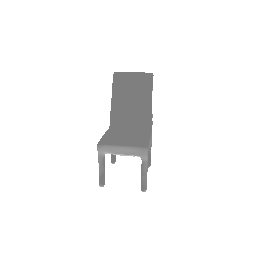

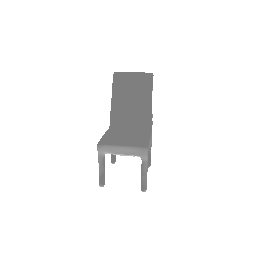

 38%|████████████████████████▍                                        | 24/64 [00:14<00:24,  1.65it/s]

Saved: logs/transformer-sanity/labels/24-z_set.gif
Saved: logs/transformer-sanity/labels/24-z_shape.gif


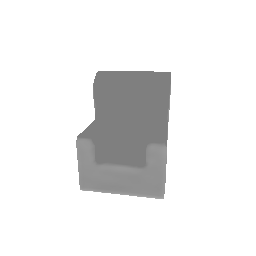

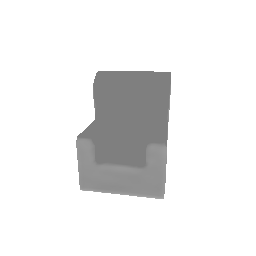

 39%|█████████████████████████▍                                       | 25/64 [00:15<00:23,  1.66it/s]

Saved: logs/transformer-sanity/labels/25-z_set.gif
Saved: logs/transformer-sanity/labels/25-z_shape.gif


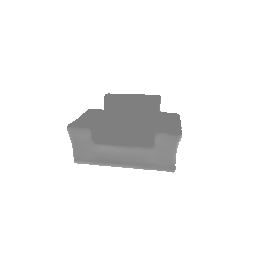

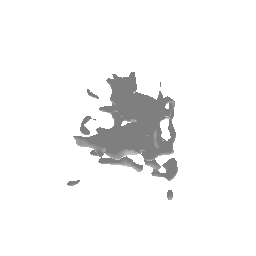

 41%|██████████████████████████▍                                      | 26/64 [00:15<00:23,  1.62it/s]

Saved: logs/transformer-sanity/labels/26-z_set.gif
Saved: logs/transformer-sanity/labels/26-z_shape.gif


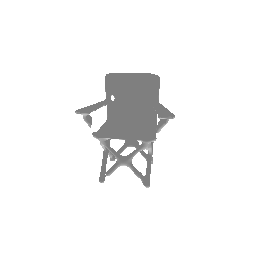

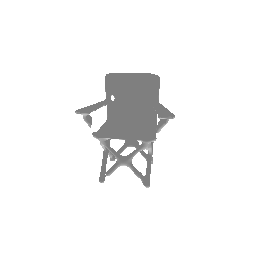

 42%|███████████████████████████▍                                     | 27/64 [00:16<00:22,  1.62it/s]

Saved: logs/transformer-sanity/labels/27-z_set.gif
Saved: logs/transformer-sanity/labels/27-z_shape.gif


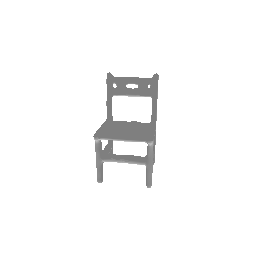

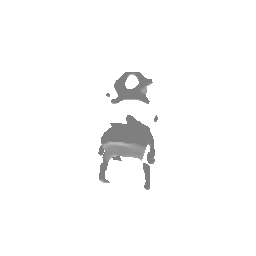

 44%|████████████████████████████▍                                    | 28/64 [00:17<00:22,  1.60it/s]

Saved: logs/transformer-sanity/labels/28-z_set.gif
Saved: logs/transformer-sanity/labels/28-z_shape.gif


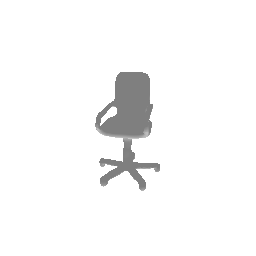

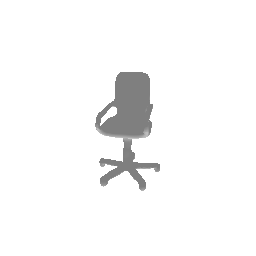

 45%|█████████████████████████████▍                                   | 29/64 [00:17<00:21,  1.60it/s]

Saved: logs/transformer-sanity/labels/29-z_set.gif
Saved: logs/transformer-sanity/labels/29-z_shape.gif


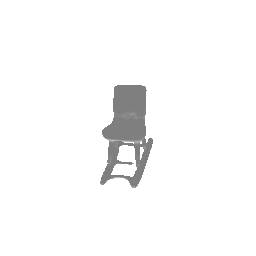

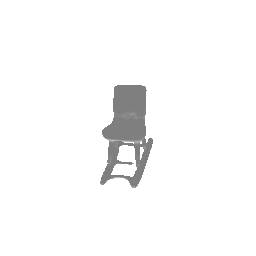

 47%|██████████████████████████████▍                                  | 30/64 [00:18<00:20,  1.63it/s]

Saved: logs/transformer-sanity/labels/30-z_set.gif
Saved: logs/transformer-sanity/labels/30-z_shape.gif


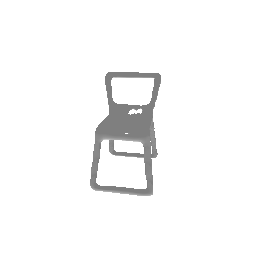

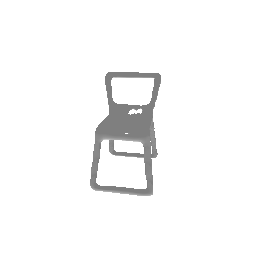

 48%|███████████████████████████████▍                                 | 31/64 [00:18<00:20,  1.59it/s]

Saved: logs/transformer-sanity/labels/31-z_set.gif
Saved: logs/transformer-sanity/labels/31-z_shape.gif


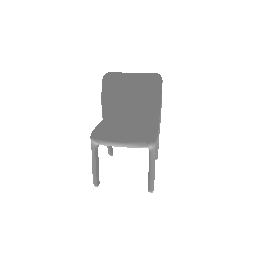

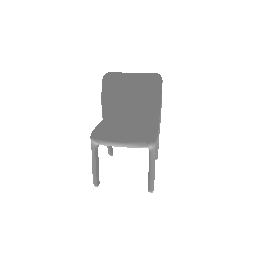

 50%|████████████████████████████████▌                                | 32/64 [00:19<00:20,  1.59it/s]

Saved: logs/transformer-sanity/labels/32-z_set.gif
Saved: logs/transformer-sanity/labels/32-z_shape.gif


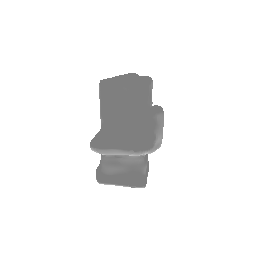

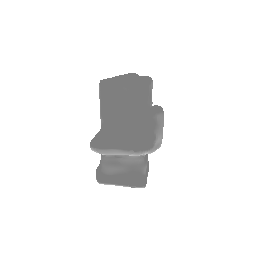

 52%|█████████████████████████████████▌                               | 33/64 [00:20<00:19,  1.62it/s]

Saved: logs/transformer-sanity/labels/33-z_set.gif
Saved: logs/transformer-sanity/labels/33-z_shape.gif


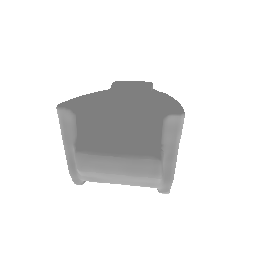

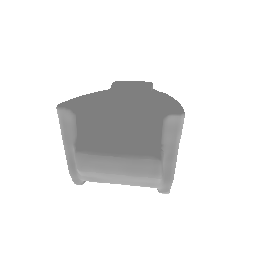

 53%|██████████████████████████████████▌                              | 34/64 [00:20<00:18,  1.63it/s]

Saved: logs/transformer-sanity/labels/34-z_set.gif
Saved: logs/transformer-sanity/labels/34-z_shape.gif


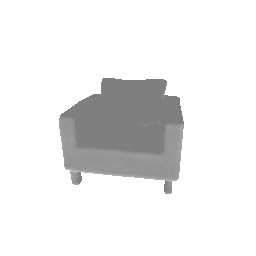

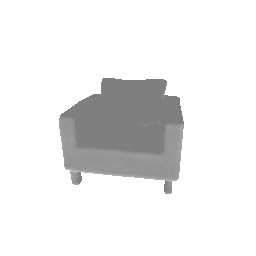

 55%|███████████████████████████████████▌                             | 35/64 [00:21<00:17,  1.63it/s]

Saved: logs/transformer-sanity/labels/35-z_set.gif
Saved: logs/transformer-sanity/labels/35-z_shape.gif


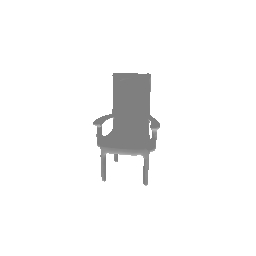

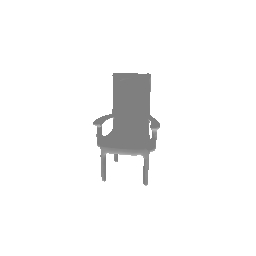

 56%|████████████████████████████████████▌                            | 36/64 [00:21<00:17,  1.64it/s]

Saved: logs/transformer-sanity/labels/36-z_set.gif
Saved: logs/transformer-sanity/labels/36-z_shape.gif


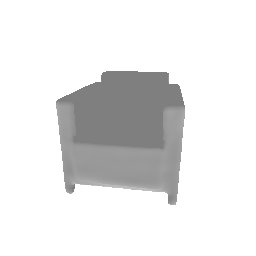

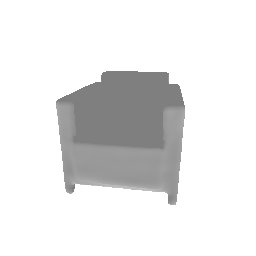

 58%|█████████████████████████████████████▌                           | 37/64 [00:22<00:16,  1.66it/s]

Saved: logs/transformer-sanity/labels/37-z_set.gif
Saved: logs/transformer-sanity/labels/37-z_shape.gif


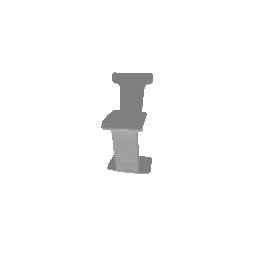

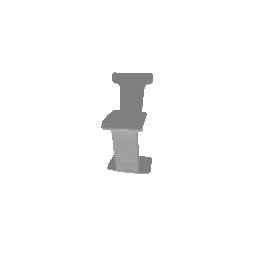

 59%|██████████████████████████████████████▌                          | 38/64 [00:23<00:15,  1.66it/s]

Saved: logs/transformer-sanity/labels/38-z_set.gif
Saved: logs/transformer-sanity/labels/38-z_shape.gif


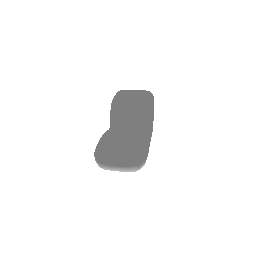

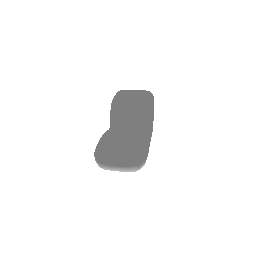

 61%|███████████████████████████████████████▌                         | 39/64 [00:23<00:15,  1.66it/s]

Saved: logs/transformer-sanity/labels/39-z_set.gif
Saved: logs/transformer-sanity/labels/39-z_shape.gif


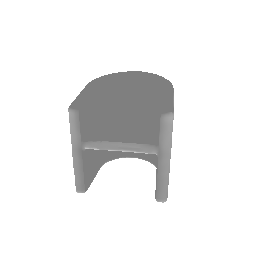

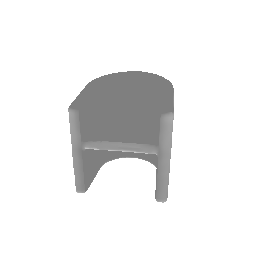

 62%|████████████████████████████████████████▋                        | 40/64 [00:24<00:14,  1.65it/s]

Saved: logs/transformer-sanity/labels/40-z_set.gif
Saved: logs/transformer-sanity/labels/40-z_shape.gif


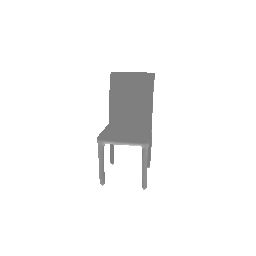

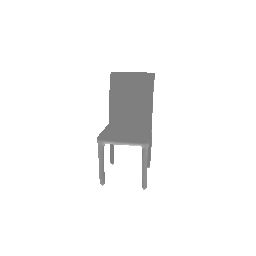

 64%|█████████████████████████████████████████▋                       | 41/64 [00:24<00:13,  1.66it/s]

Saved: logs/transformer-sanity/labels/41-z_set.gif
Saved: logs/transformer-sanity/labels/41-z_shape.gif


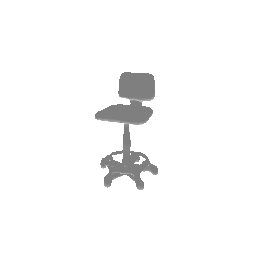

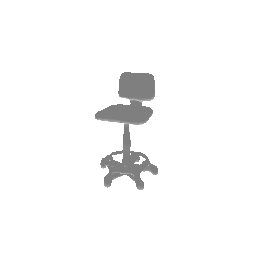

 66%|██████████████████████████████████████████▋                      | 42/64 [00:25<00:13,  1.66it/s]

Saved: logs/transformer-sanity/labels/42-z_set.gif
Saved: logs/transformer-sanity/labels/42-z_shape.gif


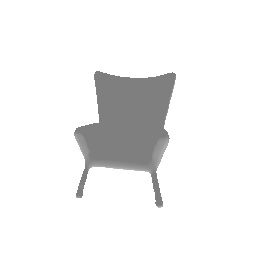

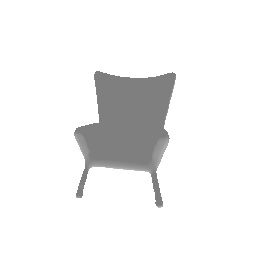

 67%|███████████████████████████████████████████▋                     | 43/64 [00:26<00:12,  1.65it/s]

Saved: logs/transformer-sanity/labels/43-z_set.gif
Saved: logs/transformer-sanity/labels/43-z_shape.gif


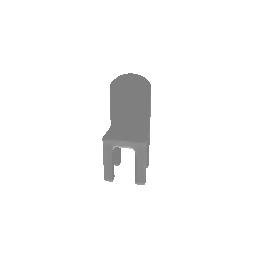

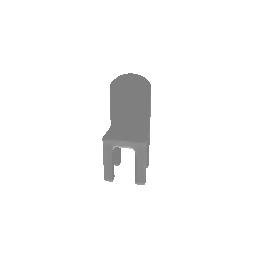

 69%|████████████████████████████████████████████▋                    | 44/64 [00:26<00:12,  1.66it/s]

Saved: logs/transformer-sanity/labels/44-z_set.gif
Saved: logs/transformer-sanity/labels/44-z_shape.gif


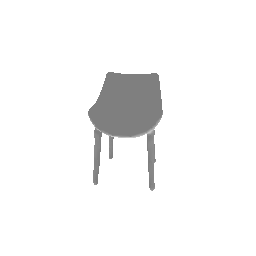

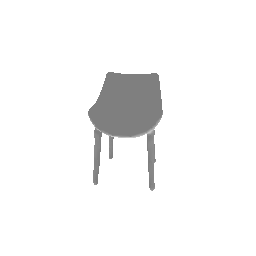

 70%|█████████████████████████████████████████████▋                   | 45/64 [00:27<00:11,  1.63it/s]

Saved: logs/transformer-sanity/labels/45-z_set.gif
Saved: logs/transformer-sanity/labels/45-z_shape.gif


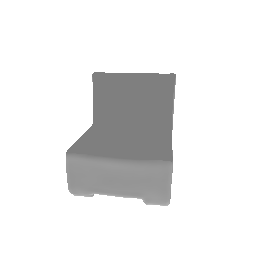

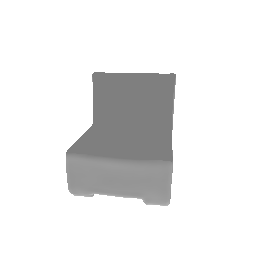

 72%|██████████████████████████████████████████████▋                  | 46/64 [00:28<00:11,  1.61it/s]

Saved: logs/transformer-sanity/labels/46-z_set.gif
Saved: logs/transformer-sanity/labels/46-z_shape.gif


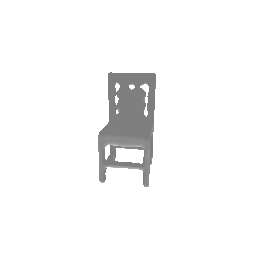

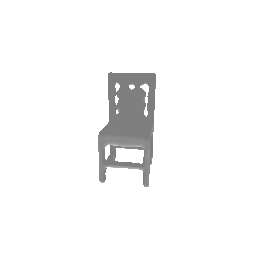

 73%|███████████████████████████████████████████████▋                 | 47/64 [00:28<00:10,  1.63it/s]

Saved: logs/transformer-sanity/labels/47-z_set.gif
Saved: logs/transformer-sanity/labels/47-z_shape.gif


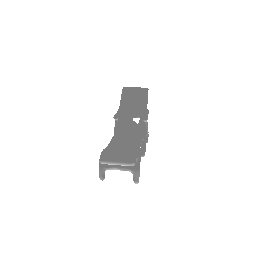

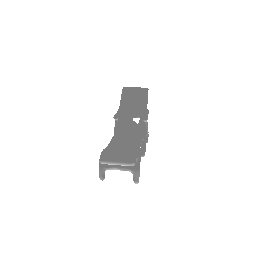

 75%|████████████████████████████████████████████████▊                | 48/64 [00:29<00:09,  1.63it/s]

Saved: logs/transformer-sanity/labels/48-z_set.gif
Saved: logs/transformer-sanity/labels/48-z_shape.gif


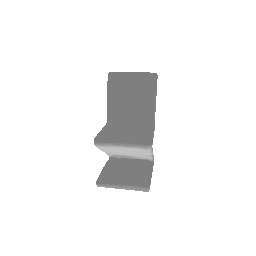

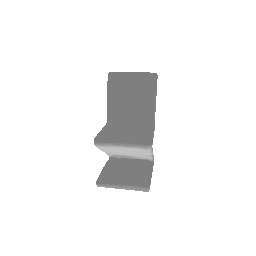

 77%|█████████████████████████████████████████████████▊               | 49/64 [00:29<00:09,  1.63it/s]

Saved: logs/transformer-sanity/labels/49-z_set.gif
Saved: logs/transformer-sanity/labels/49-z_shape.gif


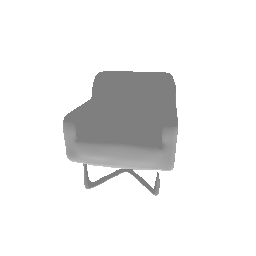

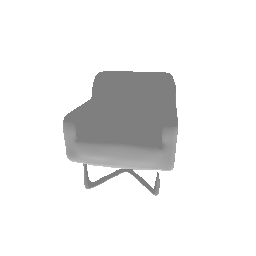

 78%|██████████████████████████████████████████████████▊              | 50/64 [00:30<00:08,  1.64it/s]

Saved: logs/transformer-sanity/labels/50-z_set.gif
Saved: logs/transformer-sanity/labels/50-z_shape.gif


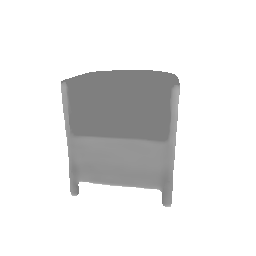

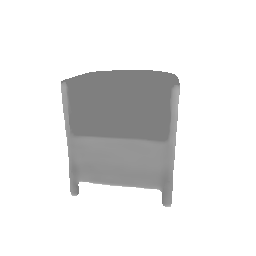

 80%|███████████████████████████████████████████████████▊             | 51/64 [00:31<00:07,  1.64it/s]

Saved: logs/transformer-sanity/labels/51-z_set.gif
Saved: logs/transformer-sanity/labels/51-z_shape.gif


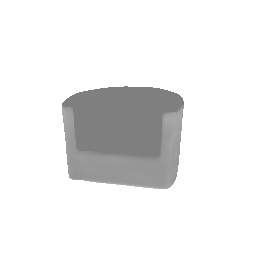

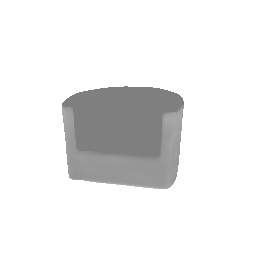

 81%|████████████████████████████████████████████████████▊            | 52/64 [00:31<00:07,  1.64it/s]

Saved: logs/transformer-sanity/labels/52-z_set.gif
Saved: logs/transformer-sanity/labels/52-z_shape.gif


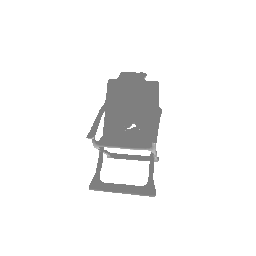

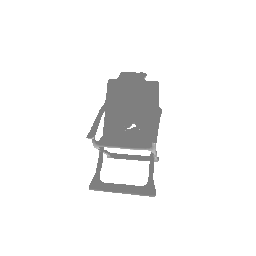

 83%|█████████████████████████████████████████████████████▊           | 53/64 [00:32<00:06,  1.65it/s]

Saved: logs/transformer-sanity/labels/53-z_set.gif
Saved: logs/transformer-sanity/labels/53-z_shape.gif


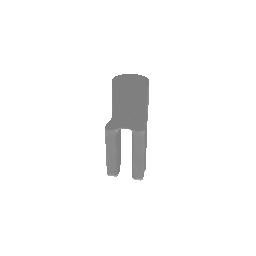

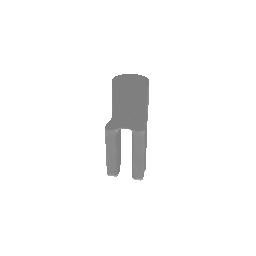

 84%|██████████████████████████████████████████████████████▊          | 54/64 [00:32<00:06,  1.66it/s]

Saved: logs/transformer-sanity/labels/54-z_set.gif
Saved: logs/transformer-sanity/labels/54-z_shape.gif


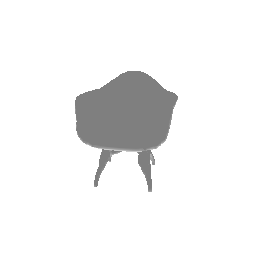

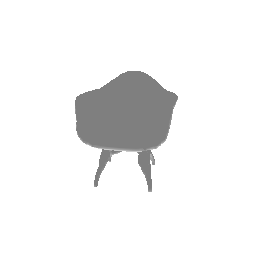

 86%|███████████████████████████████████████████████████████▊         | 55/64 [00:33<00:05,  1.65it/s]

Saved: logs/transformer-sanity/labels/55-z_set.gif
Saved: logs/transformer-sanity/labels/55-z_shape.gif


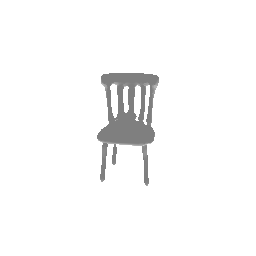

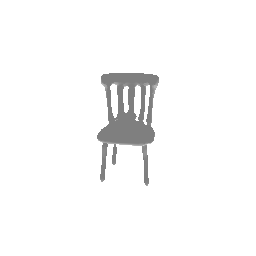

 88%|████████████████████████████████████████████████████████▉        | 56/64 [00:34<00:04,  1.67it/s]

Saved: logs/transformer-sanity/labels/56-z_set.gif
Saved: logs/transformer-sanity/labels/56-z_shape.gif


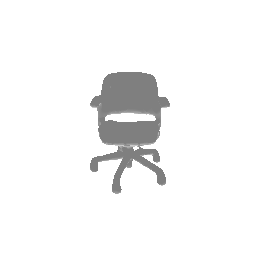

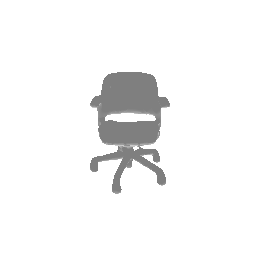

 89%|█████████████████████████████████████████████████████████▉       | 57/64 [00:34<00:04,  1.65it/s]

Saved: logs/transformer-sanity/labels/57-z_set.gif
Saved: logs/transformer-sanity/labels/57-z_shape.gif


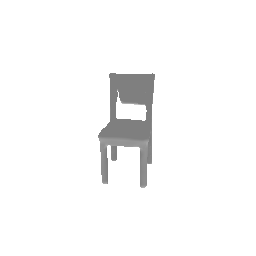

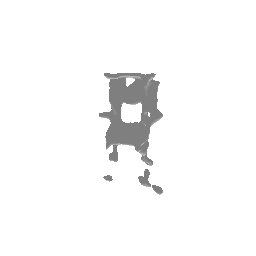

 91%|██████████████████████████████████████████████████████████▉      | 58/64 [00:35<00:03,  1.66it/s]

Saved: logs/transformer-sanity/labels/58-z_set.gif
Saved: logs/transformer-sanity/labels/58-z_shape.gif


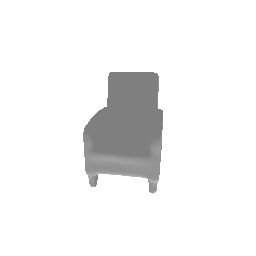

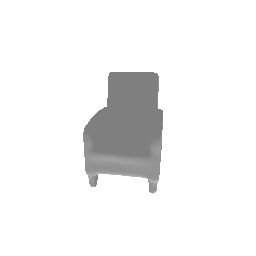

 92%|███████████████████████████████████████████████████████████▉     | 59/64 [00:35<00:03,  1.66it/s]

Saved: logs/transformer-sanity/labels/59-z_set.gif
Saved: logs/transformer-sanity/labels/59-z_shape.gif


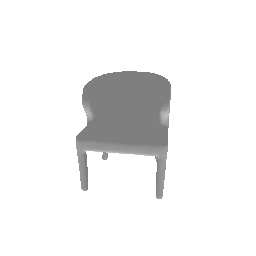

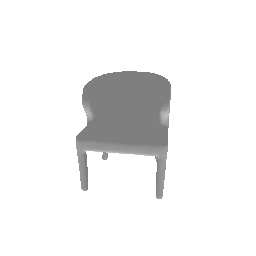

 94%|████████████████████████████████████████████████████████████▉    | 60/64 [00:36<00:02,  1.66it/s]

Saved: logs/transformer-sanity/labels/60-z_set.gif
Saved: logs/transformer-sanity/labels/60-z_shape.gif


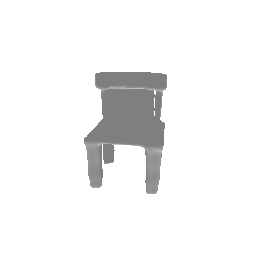

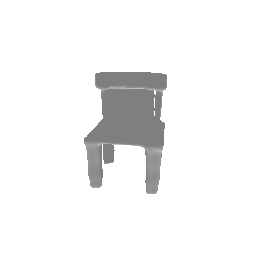

 95%|█████████████████████████████████████████████████████████████▉   | 61/64 [00:37<00:01,  1.66it/s]

Saved: logs/transformer-sanity/labels/61-z_set.gif
Saved: logs/transformer-sanity/labels/61-z_shape.gif


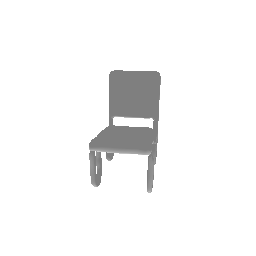

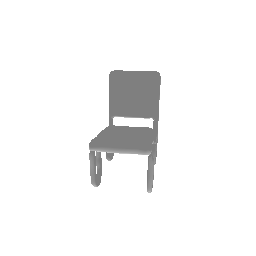

 97%|██████████████████████████████████████████████████████████████▉  | 62/64 [00:37<00:01,  1.65it/s]

Saved: logs/transformer-sanity/labels/62-z_set.gif
Saved: logs/transformer-sanity/labels/62-z_shape.gif


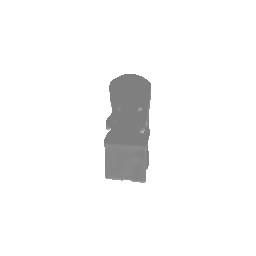

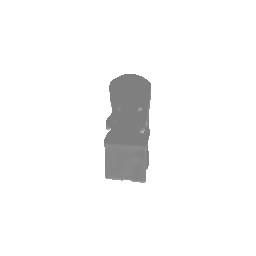

 98%|███████████████████████████████████████████████████████████████▉ | 63/64 [00:38<00:00,  1.65it/s]

Saved: logs/transformer-sanity/labels/63-z_set.gif
Saved: logs/transformer-sanity/labels/63-z_shape.gif


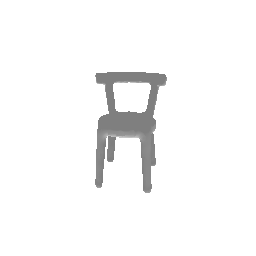

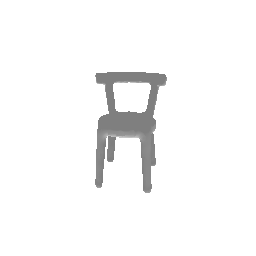

100%|█████████████████████████████████████████████████████████████████| 64/64 [00:38<00:00,  1.64it/s]


In [26]:
import torch
from utils.qual_util import get_lang_prob_recursive, save_mesh_as_pics
from einops import rearrange


gpu_id = 0
#nimgs=3

class Opt:
    def __init__(self):
        self.name = 'opt'


model = modelV5
model_name = "modelV5"
#bert2vq = bert2vqV3



nimgs=6
for j in tqdm(range(len(dataset))):
    data = dataset[j]
    z_set = data["z_shape_target"].unsqueeze(0).flatten(start_dim=1).cuda()
    z_shape = data["z_set_target"].unsqueeze(0).flatten(start_dim=1).cuda()
    z_set = model.vqvae.decode_enc_idices(z_set,  z_spatial_dim=model.grid_size)
    z_shape = model.vqvae.decode_enc_idices(z_shape,  z_spatial_dim=model.grid_size)
    gen_mesh_z_set = sdf_to_mesh(z_set)
    gen_mesh_z_shape = sdf_to_mesh(z_shape)
    gen_gif_name_zset = f'{res_dir}/{j}-z_set.gif'
    gen_gif_name_zshape = f'{res_dir}/{j}-z_shape.gif'
    try:
        save_mesh_as_pics(mesh_renderer, gen_mesh_z_set, nrow=1, out_name=gen_gif_name_zset)
        save_mesh_as_pics(mesh_renderer,gen_mesh_z_shape, nrow=1, out_name=gen_gif_name_zshape)
        print("Saved:",   gen_gif_name_zset)
        print("Saved:",   gen_gif_name_zshape)
    except e as error:
        import pdb;pdb.set_trace()
           
    for name in [gen_gif_name_zset, gen_gif_name_zshape]:
        display(ipy_image(name))